# Dépôts de brevets et marchés financiers : décrypter la valeur de l'innovation française par la Classification Internationale (CIB) 2017-2024
### Projet Python - ENSAE 2A
##### Manon Vallat, Clément Hadji, Iris Lafaille - Sous la direction de Romain Avouac

<a id="intro"></a>
## Introduction

### L'innovation comme boussole de la valeur

À l'ère de l'économie de la connaissance, la capacité d’une entreprise à innover ne constitue plus seulement un avantage compétitif, mais la condition même de sa survie et de sa valorisation sur les marchés financiers. Ce projet de recherche propose d'explorer la corrélation entre l'effort de recherche amont, mesuré par les demandes de brevets en France, et la dynamique boursière des entreprises sur une période allant de 2017 à 2024. 

Tandis que la plupart des analyses se concentrent sur les brevets déjà accordés, cette étude se focalise plutôt sur les dépôts de brevets. Ceci est dû à des contraintes d'accès aux données mais permet de capter le signal technologique à sa source, avant que les innovations ne soient traduits par les grandes entreprises en produits commerciaux ou en rapports annuels.

Ce projet propose ainsi de répondre à une problématique importante : dans quelle mesure les flux de dépôts de brevets constituent-ils un prédicteur fiable de la performance boursière et de la trajectoire stratégique des entreprises françaises ? L'objectif central est de vérifier si le flux de dépôts agit comme un réducteur d'asymétrie d'information pour les investisseurs. À travers une méthodologie croisant les données de l'INPI et les historiques de cours d'Euronext, nous cherchons à voir si l'information brevet en un bon indicateur d'anticipation de la valeur de marché.

Nous commençons par étudier les caractéristiques des demandes de brevets en France (nombre, évolutions, acteurs, secteurs, en s'appuyant notamment sur la Classification Internationale des Brevets (CIB). Puis, nous proposons notre propre classification et créons des portefeuille d'entreprises cotées en bourse afin de mener une analyse économétrique plus poussée. **décrire l'analyse économétrique !!**

### Revue de la littérature et cadre de recherche 
L’analyse des dépôts de brevets comme indicateurs de la performance économique s’inscrit à l’intersection de l’intelligence stratégique et de la finance de marché. Contrairement aux brevets accordés, les dépôts (demandes de brevets) constituent des « signaux précoces » (early signals) de l’intention technologique d’une organisation. Dans cette perspective, [Beaugency, Gatti et Regis (2012)](https://shs.cairn.info/article/RIIE_042_0153) démontrent que le brevet dépasse sa fonction strictement juridique pour devenir un outil de compréhension et d’anticipation. 

Le cadre méthodologique de cette étude repose en partie sur l'exploitation de la Classification Internationale des Brevets (CIB). Comme le soulignent [Dou et Leveillé (2015)](https://shs.cairn.info/revue-internationale-d-intelligence-economique-1-2015-1-page-25?tab=texte-integral), la CIB est un vecteur de créativité et de développement technologique : elle permet d’identifier comment les entreprises pivotent vers des solutions durables ou des domaines de rupture. L'utilisation de la CIB permet ici de segmenter l'activité d'innovation des entreprises françaises avec une granularité fine, isolant les secteurs dont l'évolution technologique est la plus "surprenante" par rapport aux standards industriels classiques.

Le lien entre ces dépôts et la « côte » boursière des entreprises s'articule autour de la théorie du signal et de la valorisation des actifs immatériels. Sur le marché financier français, le dépôt de brevet pourrait agir comme un réducteur d'asymétrie d'information. Selon cette théorie, il informerait l'investisseur sur la vitalité de la R&D et la capacité de l'entreprise à générer des rentes de monopole futures. L'originalité de notre recherche consiste à mettre en corrélation la densité des dépôts dans des classes CIB spécifiques avec l'évolution des cours de bourse, postulant que les secteurs en mutation technologique rapide (santé, transition énergétique, numérique) présentent une sensibilité boursière accrue aux flux de dépôts. Ce cadre permet ainsi de vérifier si la stratégie de propriété industrielle, constitue un prédicteur fiable de la confiance des marchés et de la valeur actionnariale sur le long terme.

## Sommaire
**[Installation](#installation)**

**[I. Préparation des données sur les demandes de brevet](#preparation)**
- [1) Importation](#import_brevets)
- [2) Sélection des variables pertinentes](#selec_brevets)
- [3) Restriction aux demandes de brevet](#restrict_brevets)
- [4) Gestion des valeurs manquantes et des incohérences](#clean_brevets)
- [5) Base finale](#base_brevets)

**[II. Analyses descriptives des demandes de brevets](#statsdesc_brevets)**
- [1) Évolutions temporelles du nombre de brevets](#statsdesc_evolution)
- [2) Statistiques sur les inventeurs et les déposants](#statsdesc_inventeurs)
- [3) Les secteurs les plus innovants](#statsdesc_secteurs)

**[III. Préparation des données sur les cours d'actions](#actions)**
- [1) Définition des secteurs](#secteurs)
- [2) Création des portefeuilles](#portefeuille)

**[IV. Modélisation](#modélisation)**
- [1) Premières régressions linéaires](#premières_reg)
- [2) Introduction de retards : prise en compte du délai d’impact de l’innovation](#lag)
- [3) Modélisation dans le secteur Automobile](#modélisation_auto)
- [4) Modélisation temporelle des rendements dans le secteur automobile](#model_temporel)
- [5) Création d'un indicateur et stratégie de trading systématique](#indicateur)

**[Conclusion et perspectives](#conclusion)**


<a id='installation'></a>
## Installation

In [1]:
!pip install -q -r requirements.txt

# Modules
import pandas as pd
import s3fs
import os
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_white, acorr_breusch_godfrey, acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Fonctions
from scripts.importation import process_all_years_s3
from scripts.cleaning import deduplicate
from scripts.stats_des import plot_top_applicants
from scripts.stats_des import plot_top_classifications
from scripts.stats_des import plot_part_classification_par_annee

In [2]:
# Pour une meilleure visualisation des variables

pd.set_option('display.max_columns', None)

<a id="preparation"></a>
## I. Préparation des données sur les demandes de brevet


<a id='import_brevets'></a>
### 1) Importation
Les données sont localisées dans des fichiers XML, chaque fichier correspondant à une demande de brevets. Ces fichiers sont directement téléchargeables depuis le serveur FTP de l'INPI, accessible via FileZilla, après avoir rempli un questionnaire et obtenu des codes d'accès transmis par l'INPI.

Pour rendre notre projet reproductible au maximum, bien que les données ne puissent pas être directement téléchargées par un utilisateur non autorisé par l'INPI, nous avons stocké les fichiers .zip tels que nous les avons initialement téléchargés dans le bucket diffusion de l'un d'entre nous. 

Concernant leur format, ces fichiers compressés contiennent chacun les informations sur toutes les demandes de brevets déposés auprès de l'INPI chaque semaine. Il y a donc 52 dossiers par année, un pour chaque semaine. Dans ces dossiers, se trouvent des informations dont nous n'avons pas besoin (ex: des schémas d'invention). Nous n'utiliserons que les données présentes dans des fichiers XML, chacun de ces fichiers contenant de nombreuses informations sur une demande de brevet déposée dans la semaine concernée.

Pour ne pas alourdir le fichier main inutilement, le code qui se charge de décompresser les fichiers, d'identifier les fichiers XML au sein de leurs arborescences et d'en extraire toutes les informations se situe dans le fichier "load_data.ipynb". La base obtenue à la fin de ce traitement préliminaire est récupérable dans notre bucket de diffusion, afin de ne pas avoir à refaire tourner le code de chargement des données. 


**Pour importer directement les données, il faut exécuter le code dans "load_data.ipynb" ou bien se connecter au bucket S3 à l'aide du code qui suit.**

In [3]:
# Connexion au bucket S3
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

ROOT_S3_PATH = "mvallat/diffusion/projet"

# Importation bucket S3
MY_BUCKET = "mvallat/diffusion"
FILE_PATH_S3 = f"{MY_BUCKET}/projet/data_brevets.parquet"

with fs.open(FILE_PATH_S3, 'rb') as file_in:
    data_brevets = pd.read_parquet(file_in)

data_brevets.head(10)

,doc-number,kind,country,status,publication_country,publication_doc-number,publication_date,publication_bopinum,publication_nature,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,citation_1_type,citation_1_text,citation_1_country,citation_1_doc-number,citation_1_date,citation_2_type,citation_2_text,citation_2_country,citation_2_doc-number,citation_2_date,citation_3_type,citation_3_text,citation_3_country,citation_3_doc-number,citation_3_date,year,application_country,application_doc-number,application_date,last-fee-payement,next-fee-payement,date-search-completed
0,3038352,A1,FR,PUBDEM,FR,3038352,20170106,2017-01,Brevet,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"2, PLACE D'ESTIENNE D'ORVES ,",PARIS,75009,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
1,3038278,A1,FR,PUBDEM,FR,3038278,20170106,2017-01,Brevet,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,NA,95 RUE D'AMSTERDAM,PARIS CEDEX 8,75378,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
2,3038409,A1,FR,PUBDEM,FR,3038409,20170106,2017-01,Brevet,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,NA,310 AVENUE BERTHELOT,LYON,69008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060


<a id='selec_brevets'></a>
### 2) Sélection des variables pertinentes


Nous commençons par ne conserver que les variables que nous utiliserons par la suite pour réaliser des statistiques descriptives ou bien pour la partie modélisation. En effet, nous avons importé toutes les données disponibles dans la base de l'INPI consultée sans réaliser de tri, il faut donc choisir les variables qu'on conserve.

Nous ne conservons pas les variables suivantes :

- `status` et `publication_nature`\
Elles renseignent l’issue de la demande de brevet (délivrance ou non). Leur prise en compte poserait en effet un biais important pour les demandes les plus récentes, qui sont encore en cours d’examen et pourraient être délivrées ultérieurement.\
Nous considérons donc les brevets exclusivement comme des demandes de brevet, indépendamment de leur statut final. Ce choix méthodologique nous paraît pertinent dans la mesure où le dépôt d’une demande constitue déjà un indicateur significatif de l’activité inventive et du niveau d’innovation par secteur, qu’elle aboutisse ou non à une délivrance.

- `country` et `publication_country` car toutes les demandes sont déposées en France.

- `publication_bopinum` car cette variable qui donne la date de publication sous le format année-numéro de semaine, or la variable de la date de publication est suffisamment précise.

- `date-search-completed`, la date de complétion de la recherche.

- Les variables au format `application_...` qui contiennent en double informations sur le pays, la date et le numéro de la demande sauf que cette balise n'est pas présente pour toutes les années. Ces variables contiennent donc beaucoup de valeurs manquantes et n'apportent aucune information nouvelle.

- Toutes les variables au format `citation_...`\
Elles renseignent sur les "citations" du brevet, c'est-à-dire les références à des documents antérieurs qui sont mentionnés parce qu’ils sont pertinents pour apprécier la nouveauté de l’invention, mais cette information ne nous intéresse pas.

- `last-fee-payement` et `next-fee-payement` qui donnent les dates de paiement du brevet passées et à venir.

- Les variables au format `agent_n_...` et `owner_n_...` qui contiennent les noms et adresses des n-ième mandataires et propriétaires des brevets. Le mandataire est la personne représentante légale du déposant auprès de l'INPI (souvent un salarié ou un cabinet externe) tandis que le propriétaire est celui détient les droits de la propriété intellectuelle (souvent le déposant). Les acteurs les plus intéressants dans la demande de brevet nous semble plutôt être les déposants et les mandataires, que nous décrirons ultérieurement.

- `publication_doc-number`, qui donne le numéro de document mais qui est identique à la variable `doc-number`, que nous conservons.


In [4]:
data_brevets = data_brevets.drop(columns = ["status", "publication_nature", "country", "publication_country", "publication_bopinum", "date-search-completed", "last-fee-payement", "next-fee-payement", 'publication_doc-number'])


data_brevets.drop(columns = data_brevets.filter(regex="^citation").columns, inplace=True)
data_brevets.drop(columns = data_brevets.filter(regex="^application").columns, inplace=True)
data_brevets.drop(columns = data_brevets.filter(regex="^(agent|owner)").columns, inplace=True)

In [5]:
data_brevets.head(5)

,doc-number,kind,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,A1,20170106,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,A1,20170106,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,A1,20170106,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,A1,20170106,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,OBERTHUR TECHNOLOGIES None,420 RUE D'ESTIENNE D'ORVES,COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GRAGNIC,ELODIE,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,BOSQUET,OLIVIER,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,3038316,A1,20170106,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,COMPAGNIE GENERALE DES ETABLISSEMENTS MICHELIN...,12 COURS SABLON,CLERMONT-FERRAND,63000,FR,MICHELIN RECHERCHE ET TECHNIQUE S.A. None,ROUTE LOUIS BRAILLE 10,GRANGES-PACCOT,1763,CH,NA,NA,NA,NA,NA,DORATO,MARGARITA,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 9,63040,FR,FLESINSKI,LIONEL,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 09,63040,FR,NA,NA,NA,NA,NA,NA,C08C 19/44 20060101AFI20150702BHFR ...,C08C 19/25 20060101ALI20150702BHFR ...,C08F 297/04 20060101ALI20150702BHFR ...,L'invention concerne un procédé de synthèse en...,2017


### 3) Restriction aux demandes de brevet

Les demandes de brevet dans notre base sont de plusieurs types, ce qui rend l'analyse peu homogène. Le document contient trois types de brevets :
- `A1` : demande de brevet  
- `A3` : demande de certificat d'utilité  
- `B1` : brevet délivré 

In [6]:
# Répartition des types 
data_brevets["kind"].value_counts()

kind
A1    107749
A3      4441
NA       102
B1         3
Name: count, dtype: int64

Concernant les types B1 (n = 3), cette base recense les demandes de brevet et n'est donc pas censée contenir un brevet B1. Probablement dû à une erreur de classification, nous décidons de retirer ces observations.


Concernant les types A3 (n = 4 441) : les certificats d'utilité sont des certificats délivrés par l'INPI qui protègent l'innovation, tout comme les brevets. En revanche la durée de protection est raccourcie (10 ans contre 20 ans) et la procédure d'examen de la demande est allégée. Pour simplifier l'analyse en la rendant plus homogène, nous ne gardons pas ces demandes A3 dans notre base.

In [7]:
# Suppression des B1
data_brevets = data_brevets[data_brevets["kind"] != "B1"]

# Suppression des A3
data_brevets = data_brevets[data_brevets["kind"] != "A3"]


Concernant les NA (n = 102), plus d'observations sont nécessaires pour décider de la manière de gérer ces NA.


In [8]:
# Observation des NA
brevets_na = data_brevets[data_brevets["kind"] == "NA"]
brevets_na

,doc-number,kind,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
285,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017
606,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017
831,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017
1153,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017
1543,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28236,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018
28556,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018
28760,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018
29096,NA,NA,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018


In [9]:
# Vérification du nombre d'informations réellement présentes
brevets_na["doc-number"].nunique()
brevets_na["invention-title"].nunique()

2

On peut constater que seules deux observations contiennent des informations. Nous pouvons donc supprimer toutes les observations qui ne contiennent que des NA. De plus, nous supprimons les deux autres observations contenant aussi des NA dans la catégorie `kind`. Enfin, nous supprimons la colonne `kind`.

In [10]:
# Suppression des observations NA
data_brevets = data_brevets[data_brevets["kind"] != "NA"]
 
 # Supression variable
data_brevets = data_brevets.drop(columns=["kind"])


### 4) Présentation des variables

Notre base est donc constituée des variables suivantes : 
- `doc-number` : numéro de publication du document de brevet.
- `publication_date` : date de publication officielle de la demande de brevet (la date correspond au lundi de la semaine de dépôt)
- `invention-title` : titre de l’invention tel que publié.
- `year` : année de publication, extraite de la date de publication.


- Variables `applicant_n_...` : nom et adresse du n-ième déposant (nous n'avons téléchargé les informations que pour les trois premiers déposants)
- Variables `inventor_n_...` : nom et adresse du n-ième inventeur (nous n'avons téléchargé les informations que pour les trois premiers inventeurs)

- `classification_1_text`, `classification_2_text`, `classification_3_text` : trois premiers codes de classification internationale des brevets (CIB / IPC), décrivant le domaine technologique de l’invention. Ces sont les variables que nous utiliseront pour mener une analyse sectorielle.

- `abstract` : résumé de l’invention tel que publié.  

In [11]:
data_brevets.head(5)

,doc-number,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,20170106,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,20170106,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,20170106,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,20170106,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,OBERTHUR TECHNOLOGIES None,420 RUE D'ESTIENNE D'ORVES,COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GRAGNIC,ELODIE,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,BOSQUET,OLIVIER,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,3038316,20170106,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,COMPAGNIE GENERALE DES ETABLISSEMENTS MICHELIN...,12 COURS SABLON,CLERMONT-FERRAND,63000,FR,MICHELIN RECHERCHE ET TECHNIQUE S.A. None,ROUTE LOUIS BRAILLE 10,GRANGES-PACCOT,1763,CH,NA,NA,NA,NA,NA,DORATO,MARGARITA,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 9,63040,FR,FLESINSKI,LIONEL,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 09,63040,FR,NA,NA,NA,NA,NA,NA,C08C 19/44 20060101AFI20150702BHFR ...,C08C 19/25 20060101ALI20150702BHFR ...,C08F 297/04 20060101ALI20150702BHFR ...,L'invention concerne un procédé de synthèse en...,2017


<a id='clean_brevets'></a>
### 5) Gestion des valeurs manquantes et des incohérences

Cette partie est consacrée au nettoyage des données. Nous nous assurons que la base contient bien une observation pour chaque demande de brevet et qu'il n'y a pas de doublons car cela fausserait nos analyses.

- **Unicité du numéro du document**

In [12]:
# Vérification que doc_number est unique

nb_number = data_brevets["doc-number"].nunique()
print("Nombre de doc-number uniques :", nb_number)

nb_observations = data_brevets.shape[0]
print("Nombre total d'observations :", nb_observations)

Nombre de doc-number uniques : 107748
Nombre total d'observations : 107749


On constate qu'il n'y a qu'un cas de brevet ayant le même numéro. Nous décidons de garder la demande la plus récente en retenant la demande avec le numéro de dossier le plus récent.

In [13]:
# Repérage des doublons
doublons = data_brevets[data_brevets.duplicated(subset=["doc-number"], keep=False)]
doublons

,doc-number,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
12476,3050837,20171103,"DISPOSITIF D'INFORMATION INERTIELLE, SAGITTALE...",BOARDING RING READING SAS None,661 CHE DU CHATEAU VALLON,OLLIOULES,83190,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,JEANNIN,HUBERT,661 CHEMIN DE CHATEAU-VALLON,OLLIOULES,83190,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G02C 7/08 20060101AFI20151116BHFR ...,G02C 7/10 20060101ALI20151116BHFR ...,NA,"Système d'information visuel périphérique, sag...",2017
58919,3050837,20171103,"DISPOSITIF D'INFORMATION INERTIELLE, SAGITTALE...",BOARDING RING READING SAS,661 CHE DU CHATEAU VALLON,OLLIOULES,83190,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,JEANNIN,HUBERT,661 CHEMIN DE CHATEAU-VALLON,OLLIOULES,83190,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G02C 7/08 20060101AFI20151116BHFR ...,G02C 7/10 20060101ALI20151116BHFR ...,NA,\n\t\tSystème d'information visuel périphériqu...,2020


In [14]:
# Drop de la demande indexée 12476 (on conserve le numéro 58919)
data_brevets_clean = data_brevets.drop(12476)

- **Absence d'abstract et d'intitulés vides**

In [15]:
title_NA = data_brevets_clean[
    data_brevets_clean["invention-title"] == "NA"
]
print("Nombre de titres avec NA :", len(title_NA))

abstract_NA = data_brevets_clean[
    data_brevets_clean["abstract"] == "NA"
]
print("Nombre d'abstract avec NA :", len(abstract_NA))

Nombre de titres avec NA : 1
Nombre d'abstract avec NA : 339


En observant la base de données, on constate que ces abstracts vides sont parfois associés à des demandes incomplètes, et parfois le reste de la demande semble complète. Après quelques recherches sur internet, il nous semble que l'explication la plus probable est que ces demandes soient déposées sans leur abstract, qui est fourni plus tard à l'INPI (l'abstract étant obligatoire pour la demande). Pour se concentrer sur les demandes complètes uniquement, nous décidons donc de supprimer ces observations, qui restent en faible nombre par rapport à la taille de la base.

In [16]:
# Drop des NA
data_brevets_clean = data_brevets_clean[
    data_brevets_clean["abstract"] != "NA"
]
data_brevets_clean = data_brevets_clean[
    data_brevets_clean["invention-title"] != "NA"
]

# Vérification 
nb_na = (data_brevets_clean["abstract"] == "NA").sum()
print("Nombre de NA abstract après le drop :", nb_na)

nb_na = (data_brevets_clean["invention-title"] == "NA").sum()
print("Nombre de NA titre après le drop :", nb_na)

Nombre de NA abstract après le drop : 0
Nombre de NA titre après le drop : 0


- **Absence de titres et d'abstracts en double**

Chaque invention doit avoir un titre et un abstract (résumé du brevet). Nous allons vérifier que le titre et le résumé ne sont pas vides d'une part, et qu'il n'y a pas de doublons d'autre part, afin de s'assurer que chaque numéro de demande correspond bien à une demande effective différente.

In [17]:
counts_abstract = data_brevets_clean["abstract"].value_counts()
print("Nombre d'abstract en double :", len(counts_abstract[counts_abstract > 1]))

counts_title = data_brevets_clean["invention-title"].value_counts()
print("Nombre de titres en double :", len(counts_title[counts_title > 1]))

Nombre d'abstract en double : 1165
Nombre de titres en double : 5455


On peut d'abord vérifier si il existe des observations qui ont exactement les mêmes valeurs pour toutes les variables sauf pour le numéro de dossier.

In [18]:
# Vérification existance doublon parfait
cols_comparaison = [
    c for c in data_brevets_clean.columns
    if c not in ["doc_number", "publication_doc_number"]
]


n_duplicates = data_brevets_clean.duplicated(
    subset=cols_comparaison
).sum()
print(n_duplicates)

0


Il n'y a donc aucun doublon parfait ! Toutes les demandes avec le même abstract ne sont pas identiques pour toutes les variables (au-delà du fait que les demandes n'ont pas le même numéro).

Pour ce qui concerne les doublons, nous émettons l'hypothèse que les observations avec le même titre correspondent à la même demande de brevet déposée plusieurs fois afin d'ajouter une correction d'une version à une autre. Ainsi, nous considérons que la demande la plus récente entre les doublons est la demande la plus aboutie, et donc celle que nous garderons, en se basant donc sur la date de la demande. Dans le cas où la date est la même, il suffit de garder la demande avec le numéro de dossier le plus élevé car ce numéro augmente d'une unité pour chaque nouvelle demande.

In [19]:
df = data_brevets_clean.copy()

df["publication_date"] = pd.to_datetime(
    df["publication_date"],
    format="%Y%m%d",
    errors="coerce"
)

df["doc-number"] = pd.to_numeric(
    df["doc-number"],
    errors="coerce"
)

In [20]:
duplicates_title = df[df.duplicated(subset="invention-title", keep=False)]
print("Doublons par titre (avant):", len(duplicates_title))

df = deduplicate(df, "invention-title")

duplicates_title_after = df[df.duplicated(subset="invention-title", keep=False)]
print("Doublons par titre (après):", len(duplicates_title_after))

print("Nombre d'observations:", len(df))
print("Titres uniques:", df["invention-title"].nunique())


Doublons par titre (avant): 14244


Doublons par titre (après): 0
Nombre d'observations: 98619
Titres uniques: 98619


In [21]:
duplicates_abstract = df[df.duplicated(subset="abstract", keep=False)]
print("Doublons par abstract (avant):", len(duplicates_abstract))

df = deduplicate(df, "abstract")

duplicates_abstract_after = df[df.duplicated(subset="abstract", keep=False)]
print("Doublons par abstract (après):", len(duplicates_abstract_after))


Doublons par abstract (avant): 825
Doublons par abstract (après): 0


- **Vérification de la cohérence des variables de date**

In [22]:
# Min et max pour l'année
data_brevets_clean[['year']] = data_brevets_clean[['year']].apply(
    pd.to_numeric, errors='coerce'
)

data_brevets_clean[['year']].describe()

,year
count,107408.000000
mean,2020.331316
std,2.279431
min,2017.000000
25%,2018.000000
50%,2020.000000
75%,2022.000000
max,2024.000000


In [23]:
# Min et max pour la date de publication
data_brevets_clean['publication_date'] = pd.to_datetime(
    data_brevets_clean['publication_date'],
    errors='coerce'
)

print(data_brevets_clean['publication_date'].min())
print(data_brevets_clean['publication_date'].max())


1991-10-31 00:00:00
2024-12-27 00:00:00


In [24]:
# Nombre d'observations avec valeurs avant 2017 :
mask = data_brevets_clean['publication_date'] < '2017-01-01'
print(f"Nombre d'observations avec des valeurs avant 2017 :", mask.sum())


Nombre d'observations avec des valeurs avant 2017 : 39


In [25]:
data_brevets_clean.loc[mask].head(5)

,doc-number,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
37496,2873114,2006-01-20,ARTICLE A LIAISON METAL-CERAMIQUE ET PROCEDE D...,DENSO CORPORATION,1 1 SHOWA CHO 448 8661 KARIYA CITY AICHI PREF,NA,NA,JP,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,KUZUOKA,KAORU,CO DENSO CORP 1 1 SHOWA CHO KARIYA CITY,AICHI PREF 448 8661 JAPON,NA,JP,YAMADA,KATSUNORI,41 1 AZA YOKOMICHI OAZA NAGAKUTE NAGAKUTE CHO...,480 1192 AICHI GUN JAPON,NA,JP,KOBAYASHI,TAKAO,41 1 AZA YOKOMICHI OAZA NAGAKUTE NAGAKUTE CHO...,480 1192 AICHI GUN JAPON,NA,JP,C04B 37/02 20060101AFI20070504BHFR ...,B32B 15/04 20060101A I20070224RMEP ...,C22C 19/05 20060101ALI20060310RMJP ...,Un article à liaison métal-céramique comprend ...,2019
37506,2873023,2006-01-20,EMULSION H/E FINE ET DON UTILISATION DANS LE D...,L'OREAL,14 RUE ROYALE,PARIS,75008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,SEBILLOTTE ARNAUD,LAURENCE,18 RUE DE LA BERGERE,L HAY LES ROSES,94240,FR,AUBRUN,ODILE,9 RUE D ALESIA,PARIS,75014,FR,NA,NA,NA,NA,NA,NA,A61K 8/34 20060101AFI20071102BHFR ...,A61K 8/06 20060101A I20051008RMEP ...,A61K 8/37 20060101A I20051008RMEP ...,La présente invention a trait à une compositio...,2019
37559,2873140,2006-01-20,SOCLE PROFILE POUR BARRE DE SEUIL,DINAC,ZI DES MARAIS,LA MURE,38350,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,ROGEAT,ROMAIN,22 LOT LES CASTORS,LA MURE,38350,FR,GERGONNE,MICHEL,35 RUE DU MAQUIS MARCHON ARBENT,OYONNAX,01100,FR,NA,NA,NA,NA,NA,NA,E04F 19/02 20060101AFI20080222BHFR ...,E04F 15/02 20060101A I20051008RMEP ...,E04F 19/06 20060101A I20051008RMEP ...,L'invention concerne un socle (10) de barre de...,2019
37692,2873022,2006-01-20,"EMULSION H/E RICHE EN HUILE, ET SON UTILISATIO...",L'OREAL,14 RUE ROYALE,PARIS,75008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,SEBILLOTTE ARNAUD,LAURENCE,18 RUE DE LA BERGERE,L HAY LES ROSES,94240,FR,BORDEAUX,DOMINIQUE,19 RUE DE VILLIERS,LONGPONT SUR ORGE,91310,FR,NA,NA,NA,NA,NA,NA,A61K 8/34 20060101AFI20060901BHFR ...,A61K 8/04 20060101A I20051008RMEP ...,A61K 8/06 20060101A I20051008RMEP ...,La présente invention a trait à une compositio...,2019
37809,2873166,2006-01-20,TUYERE DE TURBOMACHINE A MOTIFS A REDUCTION DE...,SNECMA MOTEURS,2 BD DU GENERAL MARTIAL VALIN,PARIS,75015,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GOUTINES,MARIUS,9 AV PATTON,MELUN,77000,FR,JULLIARD,JACQUES MICHEL ALBERT,26 RUE DES SOURCES,HERICY SUR SEINE,77850,FR,LOHEAC,PIERRE,8 RUE DE LA MADELEINE,BRIE COMTE ROBERT,77170,FR,F02K 1/48 20060101AFI20081031BHFR ...,F02K 1/38 20060101A I20051008RMEP ...,F02K 1/46 20060101A I20051008RMEP ...,"Tuyère (10) de turbomachine, comportant un cap...",2019


Il y a donc quelques observations pour lesquelles la date de publication de la demande est incohérente avec la date du dossier dans lesquelles elles se trouvent. Après avoir fait des recherches dans la documentation, nous ne trouvons aucune explication, la date de publication étant censée être comprise entre 2017 et 2024 pour ces demandes.\
Nous décidons de supprimer ces observations en les considérant comme des erreurs de classification de la part de l'INPI. 


In [26]:
data_brevets_finale = data_brevets_clean[data_brevets_clean["publication_date"] >= "2017-01-01"]

<a id='base_brevets'></a>
### 6) Base finale

Après le nettoyage des données, nous travaillerons avec la base `data_brevets_finale`.

In [27]:
data_brevets_finale.head(5)


,doc-number,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,2017-01-06,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,2017-01-06,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,2017-01-06,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,2017-01-06,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,OBERTHUR TECHNOLOGIES None,420 RUE D'ESTIENNE D'ORVES,COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GRAGNIC,ELODIE,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,BOSQUET,OLIVIER,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,3038316,2017-01-06,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,COMPAGNIE GENERALE DES ETABLISSEMENTS MICHELIN...,12 COURS SABLON,CLERMONT-FERRAND,63000,FR,MICHELIN RECHERCHE ET TECHNIQUE S.A. None,ROUTE LOUIS BRAILLE 10,GRANGES-PACCOT,1763,CH,NA,NA,NA,NA,NA,DORATO,MARGARITA,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 9,63040,FR,FLESINSKI,LIONEL,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 09,63040,FR,NA,NA,NA,NA,NA,NA,C08C 19/44 20060101AFI20150702BHFR ...,C08C 19/25 20060101ALI20150702BHFR ...,C08F 297/04 20060101ALI20150702BHFR ...,L'invention concerne un procédé de synthèse en...,2017


De plus, nous créons une base allégée `data_brevets_light` qui ne contient plus les variables pour les déposants et inventeurs. Ces variables seront intéressantes pour faire quelques statistiques descriptives mais elles sont nombreuses, ce qui complique l'exploration des données, et ne nous seront pas utiles pour notre analyse.

In [28]:
data_brevets_light = data_brevets_finale.drop(columns=data_brevets_finale.filter(regex="^(applicant|inventor)").columns)

data_brevets_light.head(5)

,doc-number,publication_date,invention-title,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,2017-01-06,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,2017-01-06,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,2017-01-06,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,2017-01-06,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,3038316,2017-01-06,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,C08C 19/44 20060101AFI20150702BHFR ...,C08C 19/25 20060101ALI20150702BHFR ...,C08F 297/04 20060101ALI20150702BHFR ...,L'invention concerne un procédé de synthèse en...,2017


<a id='statsdesc_brevets'></a>
## II. Analyses descriptives des demandes de brevet

<a id='statsdesc_evolution'></a>
### 1) Évolutions temporelles du nombre de brevets

Nous commençons par observer l'évolution dans le temps du nombre de demandes de brevets déposées entre 2017 et 2014. Pour cela, nous regroupons pas date les observations.

In [29]:
evolution_brevets = (
    data_brevets_light
    .groupby("publication_date")
    .size()
    .rename("nb_brevets")
    .reset_index()
)
evolution_brevets

,publication_date,nb_brevets
0,2017-01-06,278
1,2017-01-13,312
2,2017-01-20,212
3,2017-01-27,314
4,2017-02-03,377
...,...,...
412,2024-11-29,252
413,2024-12-06,285
414,2024-12-13,262
415,2024-12-20,294


- **Évolution annuelle**

In [30]:
# Extraire l'année
evolution_brevets["year"] = evolution_brevets["publication_date"].dt.year

brevets_annuels = (
    evolution_brevets
    .groupby("year")["nb_brevets"]
    .sum()
    .reset_index()
)

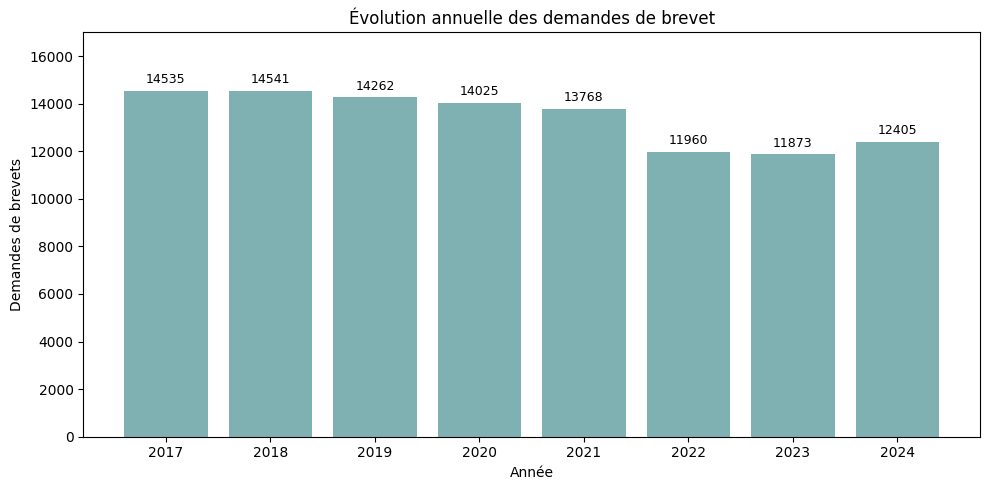

In [31]:
# Figure 
plt.figure(figsize=(10, 5))

bars = plt.bar(
    brevets_annuels["year"].astype(str),
    brevets_annuels["nb_brevets"],
    color="cadetblue",
    alpha=0.8
)

plt.title("Évolution annuelle des demandes de brevet")
plt.xlabel("Année")
plt.ylabel("Demandes de brevets")

plt.ylim(0, 17000)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 200, 
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=9
    )


plt.tight_layout()
plt.show()


On constate que le nombre de demandes est relativement constant dans le temps. Sur notre période, cela va de 11 767 en 2023 à 14 136 en 2018.

- **Évolution mensuelle**

In [32]:
# Extraire le mois
evolution_brevets["year_month"] = evolution_brevets["publication_date"].dt.to_period("M")

brevets_mensuels = (
    evolution_brevets
    .groupby("year_month")["nb_brevets"]
    .sum()
    .reset_index()
)

# Liste des années
brevets_mensuels["year"] = brevets_mensuels["year_month"].dt.year
years = brevets_mensuels["year"].unique()


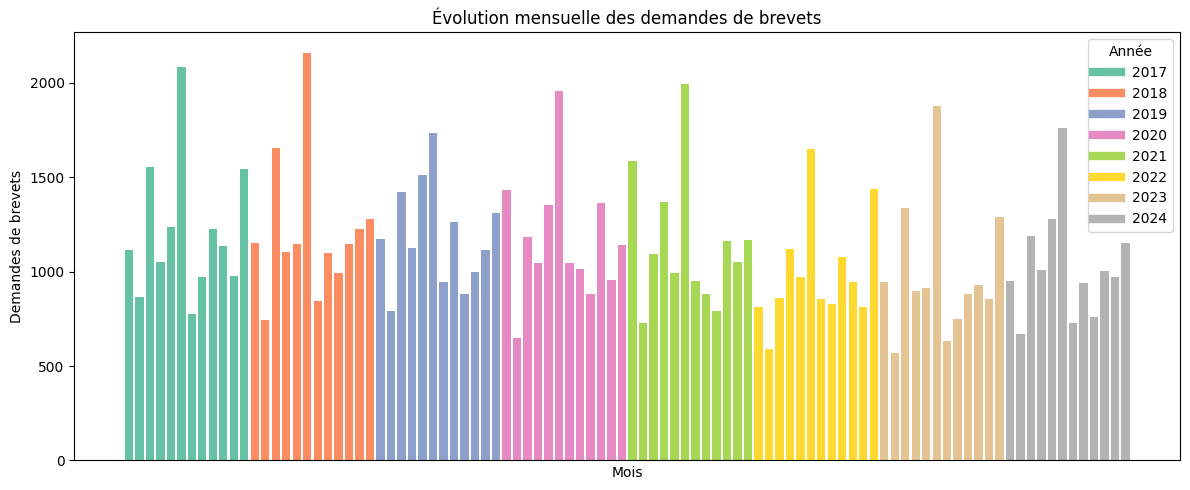

In [33]:
# Figure

cmap = plt.cm.Set2
color_map = {year: cmap(i) for i, year in enumerate(years)} # Palette de couleurs

colors = brevets_mensuels["year"].map(color_map)
plt.figure(figsize=(12, 5))

plt.bar(
    brevets_mensuels["year_month"].astype(str),
    brevets_mensuels["nb_brevets"],
    color=colors
)

plt.title("Évolution mensuelle des demandes de brevets")
plt.xlabel("Mois")
plt.ylabel("Demandes de brevets")

plt.xticks([])

handles = [
    plt.Line2D([0], [0], color=color_map[year], lw=6)
    for year in years
]

plt.legend(handles, years, title="Année")

plt.tight_layout()
plt.show()


Ce qu'on observe est assez étonnant car il semblerait que le nombre de demandes de brevets par mois évolue de la même manière chaque année. Il semble y avoir un pic en juin, souvent des pics en janvier, mars et décembre et des creux en février, juillet et septembre.

Nous voyons plusieurs explications à ce phénomène :
- Le nombre de semaines dans le mois. Comme nous avons des données au niveau de la semaine, le nombre de demandes par mois est corrélé avec le nombre de semaines qu'il y a chaque mois. Cela pourrait expliquer pourquoi le mois de février est bas toutes les années.
- La saisonnalité administrative. Les pics en juin et en décembre pourraient être dus à la cloture des comptes des entreprises à ces moments là. De plus, les périodes de vacances comme en juillet en août sont des périodes moins productives pour les entreprises.
- L'effet d'une réglementation concernant les brevets, bien que nous n'ayons pas trouver d'informations sur des échéances éventuelles.  

<a id='statsdesc_inventeurs'></a>
### 2) Statistiques sur les inventeurs et les déposants

Nous regardons dans cette sous-partie qui sont et d'où viennent les inventeurs et les déposants en France. Cela ne rentre pas dans le cadre de notre analyse finale mais permet d'affiner notre compréhension des acteurs des demandes de brevets. 

**L'inventeur est la personne qui a conçu l'invention qui est déposée en brevet. En revanche, il n'est pas nécessairement le détenteur des droits d'exploitation de ces brevets. Le déposant, qui peut être une personne physique ou morale, est celui qui dépose la demande auprès de l'INPI et qui possède les droits d'exploitation.**

Dans cette partie, on utilise la base `data_brevets_finale` et on regarde les caractéristiques par personnes (déposants ou inventeurs) et pas par demandes de brevet. Il faut noter que ces statistiques sont partielles car nous n'avons des informations que pour les trois premiers inventeurs ou déposants (mais la moitié des demandes ont moins de 3 inventeurs, de même pour les déposants !).

In [34]:
data_brevets_finale.head(5)

,doc-number,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,2017-01-06,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,2017-01-06,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,2017-01-06,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,2017-01-06,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,OBERTHUR TECHNOLOGIES None,420 RUE D'ESTIENNE D'ORVES,COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GRAGNIC,ELODIE,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,BOSQUET,OLIVIER,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,3038316,2017-01-06,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,COMPAGNIE GENERALE DES ETABLISSEMENTS MICHELIN...,12 COURS SABLON,CLERMONT-FERRAND,63000,FR,MICHELIN RECHERCHE ET TECHNIQUE S.A. None,ROUTE LOUIS BRAILLE 10,GRANGES-PACCOT,1763,CH,NA,NA,NA,NA,NA,DORATO,MARGARITA,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 9,63040,FR,FLESINSKI,LIONEL,MANUFACTURE FRANCAISE DES PNEUMATIQUES MICHELI...,CLERMONT-FERRAND CEDEX 09,63040,FR,NA,NA,NA,NA,NA,NA,C08C 19/44 20060101AFI20150702BHFR ...,C08C 19/25 20060101ALI20150702BHFR ...,C08F 297/04 20060101ALI20150702BHFR ...,L'invention concerne un procédé de synthèse en...,2017


- **Pays des inventeurs et des déposants**

In [35]:
inventor_cols = [c for c in data_brevets_finale.columns if c.startswith("inventor_") and c.endswith("_country")]
applicant_cols = [c for c in data_brevets_finale.columns if c.startswith("applicant_") and c.endswith("_country")]

In [36]:
# Pour supprimer les NA
cols_countries = inventor_cols + applicant_cols

data_brevets_finale[cols_countries] = (
    data_brevets_finale[cols_countries]
    .replace("NA", pd.NA)
)

In [37]:
inventors_by_country = (
    data_brevets_finale[inventor_cols]
    .melt(value_name="country")
    .dropna(subset=["country"])
    .groupby("country")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_inventors")
)
inventors_by_country

,country,n_inventors
0,FR,198563
1,DE,4065
2,US,3940
3,JP,2436
4,CN,1831
...,...,...
102,ME,1
103,PK,1
104,NT,1
105,SM,1


In [38]:
# Part des inventeurs FR
total_inventors = inventors_by_country["n_inventors"].sum()

fr_inventors = (
    inventors_by_country
    .loc[inventors_by_country["country"] == "FR", "n_inventors"]
    .sum()
)

pourcentage_fr = 100 * fr_inventors / total_inventors
print(f"Part des inventeurs Français : {pourcentage_fr:.2f} %")

Part des inventeurs Français : 90.07 %


In [39]:
applicants_by_country = (
    data_brevets_finale[applicant_cols]
    .melt(value_name="country")
    .dropna(subset=["country"])
    .groupby("country")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_applicants")
)
applicants_by_country

,country,n_applicants
0,FR,108813
1,DE,3259
2,JP,1670
3,US,1483
4,CH,1256
...,...,...
85,SM,1
86,SN,1
87,TZ,1
88,VG,1


In [40]:
# Part des déposants FR
total_applicants = applicants_by_country["n_applicants"].sum()

fr_applicants = (
    applicants_by_country
    .loc[applicants_by_country["country"] == "FR", "n_applicants"]
    .sum()
)

pourcentage_fr = 100 * fr_applicants / total_applicants
print(f"Part des déposants Français : {pourcentage_fr:.2f} %")

Part des déposants Français : 89.97 %


On constate sans surprise que les inventeurs et les déposants en France sont majoritairement Français (90% pour les deux). Nous construisons un jeu de données excluant les inventeurs et déposants Français pour visualiser les nationalités (hors française) les plus fréquentes.

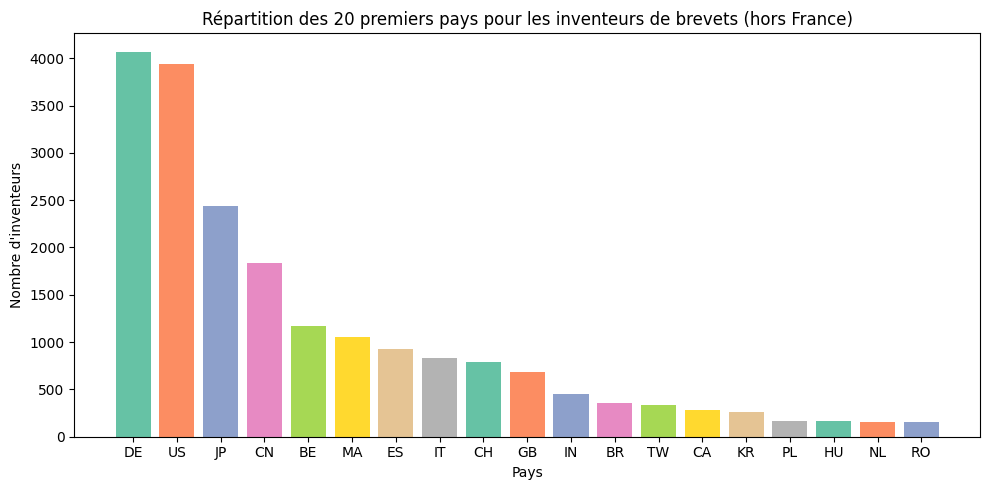

In [41]:
# Figure inventeurs hors FR
top20 = (
    inventors_by_country
    .sort_values("n_inventors", ascending=False)
    .head(20)
)

top20_hors_FR = top20[top20["country"] != "FR"]

colors = sns.color_palette("Set2", n_colors=20)

plt.figure(figsize=(10, 5))
plt.bar(top20_hors_FR["country"], top20_hors_FR["n_inventors"], color=colors)

plt.title("Répartition des 20 premiers pays pour les inventeurs de brevets (hors France)")
plt.xlabel("Pays")
plt.ylabel("Nombre d'inventeurs")

plt.xticks()
plt.tight_layout()
plt.show()


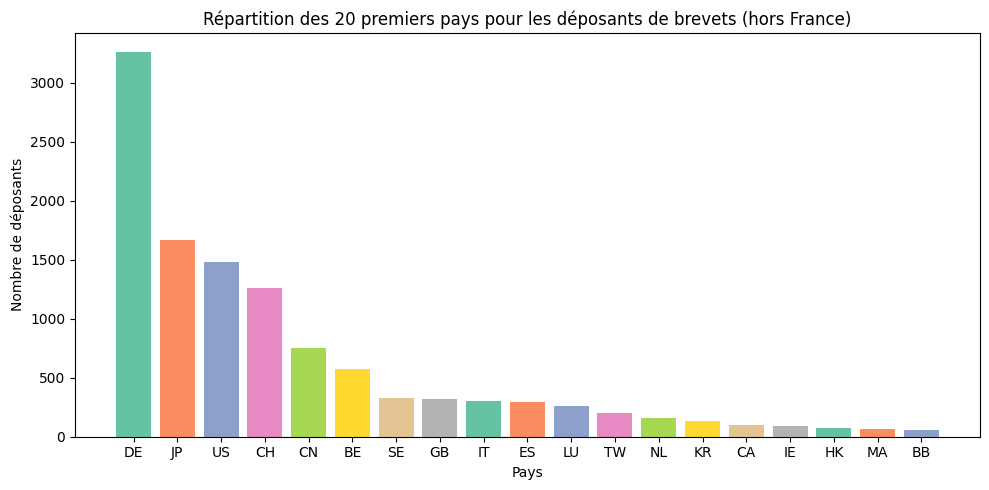

In [42]:
# Figure déposant hors FR
top20 = (
    applicants_by_country
    .sort_values("n_applicants", ascending=False)
    .head(20)
)

top20_hors_FR = top20[top20["country"] != "FR"]

colors = sns.color_palette("Set2", n_colors=20)

plt.figure(figsize=(10, 5))
plt.bar(top20_hors_FR["country"], top20_hors_FR["n_applicants"], color=colors)

plt.title("Répartition des 20 premiers pays pour les déposants de brevets (hors France)")
plt.xlabel("Pays")
plt.ylabel("Nombre de déposants")

plt.xticks()
plt.tight_layout()
plt.show()


On constate donc que les premiers pays des inventeurs après la France sont l'Allemagne, les États-Unis, le Japon, la Chine puis la Belgique. Pour les déposants l'ordre est légèrement différent : l'Allemagne, le Japon, les États-Unis puis la Suisse et la Chine.
 
Les différences de classement sont dues au fait que les déposants sont plutôt des entreprises alors que les inventeurs sont des personnes morales. On peut noter que la Suisse est très haut dans le classement des déposants mais moins dans les inventeurs 

- **Premiers déposants de brevets**

Dans cette sous-partie, nous passons à l'analyse des organisations qui déposent le plus de brevets.

In [43]:
applicant_cols = [
    "applicant_1_orgname",
    "applicant_2_orgname",
    "applicant_3_orgname"
]

On commence par supprimer les valeurs NA car ce sont uniquement des NA pour les deuxième et troisième noms d'organisation, le premier nom n'étant jamais une valeur manquante.\
De plus, nous constatons l'apparition de texte "None" à la fin de la valeur de certains noms d'organisations, ce que nous corrigeons. 

In [44]:
# Suppression des NA et des None
data_brevets_finale[applicant_cols] = (
    data_brevets_finale[applicant_cols]
    .replace(r"\b(None|NA)\b", "", regex=True)
    .apply(lambda col: col.str.strip().str.upper())
    .replace("", pd.NA)
)

In [45]:
# Passer la base au format long
applicants_long = (
    data_brevets_finale[["year"] + applicant_cols]
    .melt(
        id_vars="year",
        value_name="orgname"
    )
    .dropna(subset=["orgname"])
)

On a alors la liste des trente premières organisations qui déposent le plus de brevets.

In [46]:
pd.set_option("display.max_colwidth", None) # pour voir les noms en entier

applicants_by_org = (
    applicants_long
    .groupby("orgname")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_brevets")
)


applicants_by_org.head(30)

,orgname,n_brevets
0,PSA AUTOMOBILES SA,6430
1,COMMISSARIAT A L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES,4434
2,SAFRAN AIRCRAFT ENGINES,3264
3,L'OREAL,2823
4,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE,2058
5,RENAULT S.A.S,2027
6,VALEO SYSTEMES THERMIQUES,2005
7,PEUGEOT CITROEN AUTOMOBILES SA,1866
8,THALES,1847
9,ORANGE,1564


On constate qu'il y a dans ce top 30 des noms d'organisations qui correspondent à la même organisation. Il y a aussi des cas de filiales d'une même entreprise mère. Nous faisons quelques fusions pour avoir un meilleur aperçu des premiers déposants de brevets. 

In [47]:
# En corrigeant pour les noms d'organisations en double + fusion des filiales dans le top 30 :

ORG_FUSIONS = {
    # PSA
    "PEUGEOT CITROEN AUTOMOBILES SA": "PSA AUTOMOBILES",
    "PSA AUTOMOBILES SA": "PSA AUTOMOBILES",

    # RENAULT
    "RENAULT S.A.S": "RENAULT",
    "RENAULT S.A.S.": "RENAULT",

    # SAFRAN
    "SAFRAN": "SAFRAN",
    "SAFRAN AIRCRAFT ENGINES": "SAFRAN",
    "SAFRAN ELECTRONICS & DEFENSE": "SAFRAN",
    "SNECMA": "SAFRAN",

    # VALEO
    "VALEO SYSTEMES THERMIQUES": "VALEO",
    "VALEO VISION": "VALEO",
    "VALEO EMBRAYAGES": "VALEO",
    "VALEO EQUIPEMENTS ELECTRIQUES MOTEUR": "VALEO",
    "VALEO SYSTEMES D'ESSUYAGE": "VALEO",

    # MICHELIN
    "COMPAGNIE GENERALE DES ETABLISSEMENTS MICHELIN": "MICHELIN",
    "MICHELIN RECHERCHE ET TECHNIQUE S.A.": "MICHELIN",

    # CONTINENTAL
    "CONTINENTAL AUTOMOTIVE GMBH": "CONTINENTAL",
    "CONTINENTAL AUTOMOTIVE FRANCE": "CONTINENTAL",

    # AIRBUS
    "AIRBUS OPERATIONS": "AIRBUS",

    # SAINT-GOBAIN
    "SAINT-GOBAIN GLASS FRANCE": "SAINT-GOBAIN",

    # ALSTOM
    "ALSTOM TRANSPORT TECHNOLOGIES": "ALSTOM",

    # FAURECIA
    "FAURECIA INTERIEUR INDUSTRIE": "FAURECIA",

    # STMICROELECTRONICS
    "STMICROELECTRONICS (ROUSSET) SAS": "STMICROELECTRONICS"
}

data_brevets_finale[applicant_cols] = (
    data_brevets_finale[applicant_cols]
    .replace(ORG_FUSIONS)
)


applicants_long = (
    data_brevets_finale[["year"] + applicant_cols]
    .melt(
        id_vars="year",
        value_name="orgname"
    )
    .dropna(subset=["orgname"])
)

applicants_by_org = (
    applicants_long
    .groupby("orgname")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_brevets")
)

applicants_by_org.head(20)

,orgname,n_brevets
0,PSA AUTOMOBILES,8296
1,SAFRAN,5321
2,VALEO,5253
3,COMMISSARIAT A L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES,4434
4,RENAULT,3199
5,L'OREAL,2823
6,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE,2058
7,MICHELIN,2009
8,THALES,1847
9,ORANGE,1564


Les premiers déposants sur la période 2017-2024 semblent donc être PSA automobiles, Safran et Valeo. Parmi les acteurs publics, on retrouve assez haut le CSA et le CNRS.

On continue en observant l'évolution de ce top sur notre période.

In [48]:
applicants_by_org_year = (
    applicants_long
    .groupby(["orgname", "year"])
    .size()
    .reset_index(name="n_brevets")
)

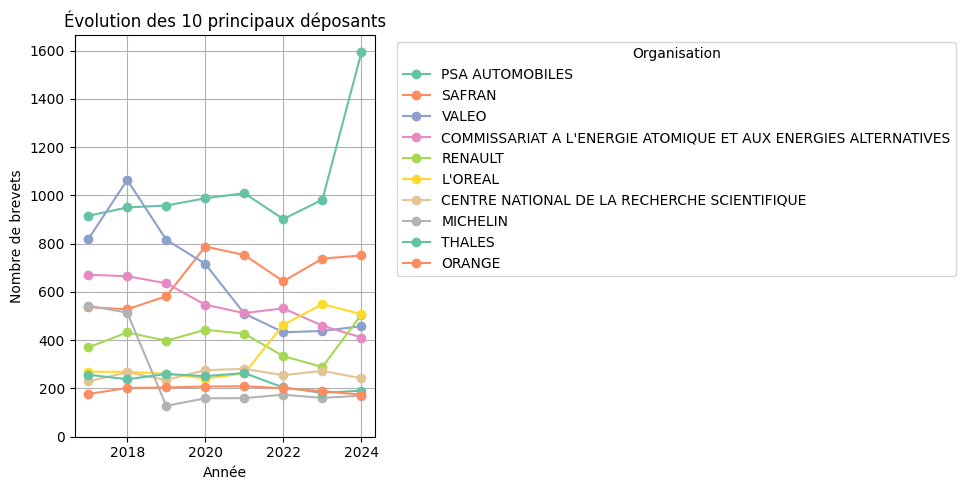

In [49]:
plot_top_applicants(applicants_by_org_year, n=10)

On observe un pic assez élevé pour PSA automobiles en 2024, ainsi qu'une forte croissance pour l'Oréal en 2022 et une chute pour Valéo en 2019. Ces évolutions peuvent être liées à beaucoup de facteurs comme la structure de l'entreprise, des évolutions de financement de R&D, ou d'autres éléments. 

<a id='statsdesc_secteurs'></a>
### 3) Les secteurs les plus innovants

Notre base de données dispose de variables "classification" qui donnent les trois premiers codes de classification CIB associés à la demande de brevet. Toutes les demandes de brevet n'ont pas trois codes de classification, elles peuvent en avoir moins ou plus selon les cas. Nous n'avons gardé que les trois premières pour alléger l'analyse ce qui peut créer des biais. Néanmoins, les codes ne sont pas classés par ordre alphabétique donc nous supposons que les premiers codes sont ceux qui sont le plus proches de l'invention. 

**La classification CIB** : 
Le système de classification détaillé peut-être retrouvé sur [le site de l'OMPI](https://ipcpub.wipo.int/?notion=scheme&version=20260101&symbol=none&menulang=en&lang=en&viewmode=f&fipcpc=no&showdeleted=yes&indexes=no&headings=yes&notes=yes&direction=o2n&initial=A&cwid=none&tree=no&searchmode=smart).
Il existe 8 grandes catégories allant de A à H, à l'intérieur desquelles on trouve plus de 70 000 subdivisions. En s'arrêtant au quatrième niveau de divisions (4 premiers lettres/chiffres), on a environ 650 classes de brevets différentes, ce qui correspond déjà à un niveau d'analyse assez fin.

- **Nettoyage de la classification**

On commence par regarder la répartition du nombre de classification des demandes de brevets.

In [50]:
# Compte des NA dans les colonnes classification
cols = ["classification_1_text", "classification_2_text", "classification_3_text"]

data_brevets_light[cols] = data_brevets_light[cols].replace("NA", pd.NA)
data_brevets_light["nb_na"] = data_brevets_light[cols].isna().sum(axis=1)

# Statistiques NA
stats_na = (
    data_brevets_light["nb_na"]
    .value_counts()
    .sort_index()
    .rename(index={
        0: "Trois codes de classification ou plus :",
        1: "Deux codes de classification :",
        2: "Un code de classification :",
        3: "Pas de classification :"
    })
)
print(stats_na)


nb_na
Trois codes de classification ou plus :    46975
Deux codes de classification :             34505
Un code de classification :                25887
Pas de classification :                        2
Name: count, dtype: int64


Moins de la moitié des brevets ont trois codes de classification ou plus, tandis que 2 n'ont aucune classification, ce qui n'est pas normal. Nous supprimons ces deux brevets sans classification qui doivent correspondre à des erreurs.

In [51]:
data_brevets_light = data_brevets_light[data_brevets_light["nb_na"] < 3]

- **Nombre de brevets déposés par catégorie (premier niveau de classification)**

Nous nous intéressons ensuite au nombre de brevets déposés pour chaque catégorie ainsi qu'à l'évolution de ce nombre entre 2017 et 2024. Nous commençons par regarder à une échelle assez large, au niveau de la première lettre de la classification.

Nous remettons ici la signification de la première lettre de la classification, telle qu'on peut la retrouver sur le site de l'OMPI :

| Lettre | Section CIB |
|--------|-------------|
| A | Nécessités courantes de la vie |
| B | Techniques industrielles; transports |
| C | Chimie; métallurgie |
| D | Textiles; papier |
| E | Constructions fixes |
| F | Mécanique; éclairage; chauffage; armement; sautage |
| G | Physique |
| H | Électricité |


In [52]:
# Garder que la première lettre de la classification
cols_classif = ["classification_1_text", "classification_2_text", "classification_3_text"]

brevets_class1 = data_brevets_light.copy()
for col in cols_classif:
    brevets_class1[col] = brevets_class1[col].str.extract(r"^\s*([A-H])")

# Créer base compte classification
brevets_class1_long = brevets_class1.melt(
    id_vars=["doc-number", "year"],
    value_vars=cols_classif,
    value_name="classification"
)

brevets_class1_long = brevets_class1_long.dropna(subset=["classification"])

# enlever doublons intra brevets
brevets_class1_long = brevets_class1_long.drop_duplicates(
    subset=["doc-number", "year", "classification"]
)

# créer base avec nombre par année
stats_class1 = (
    brevets_class1_long
    .groupby(["classification", "year"])
    .size()
    .reset_index(name="nombre")
)

stats_class1.head(10)


,classification,year,nombre
0,A,2017,2465
1,A,2018,2297
2,A,2019,2402
3,A,2020,2279
4,A,2021,2340
5,A,2022,2183
6,A,2023,2101
7,A,2024,1929
8,B,2017,4642
9,B,2018,4866


On construit deux graphiques pour observer :
1) L'évolution du nombre de brevet par lettre entre 2017 et 2024
2) La part de chaque grande catégorie dans le nombre total de demandes de brevet entre 2017 et 2024

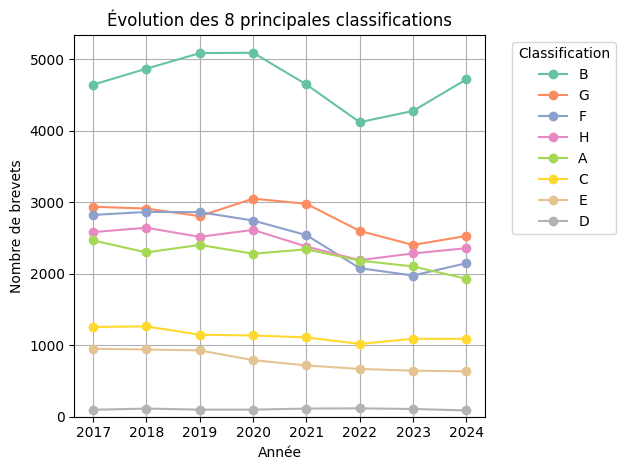

In [53]:
plot_top_classifications(stats_class1, n=8)

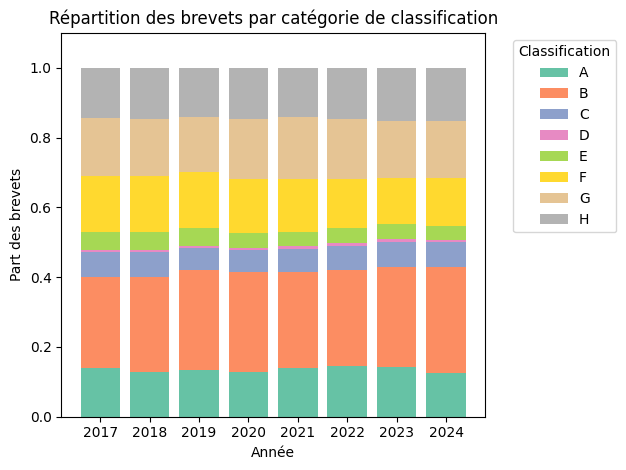

In [54]:
plot_part_classification_par_annee(stats_class1)

On constate que la catégorie B est celle qui revient le plus et que la part des différentes catégories évolue relativement peu dans le temps. Les catégories G, H, F et A se disputent les positions allant de 2 à 5, puis les catégories C, E et D sont moins nombreuses que les autres.

- **Nombre de brevets déposés par catégorie (trois premiers niveaux de classification)**

In [55]:
# Garder que la première lettre de la classification
cols_classif = ["classification_1_text", "classification_2_text", "classification_3_text"]

brevets_class3 = data_brevets_light.copy()
for col in cols_classif:
    brevets_class3[col] = brevets_class3[col].str.extract(r"^([A-Z]\d{2})")

# Créer base compte classification
brevets_class3_long = brevets_class3.melt(
    id_vars=["doc-number", "year"],
    value_vars=cols_classif,
    value_name="classification"
)

brevets_class3_long = brevets_class3_long.dropna(subset=["classification"])

# enlever doublons intra brevets
brevets_class3_long = brevets_class3_long.drop_duplicates(
    subset=["doc-number", "year", "classification"]
)

stats_class3 = (
    brevets_class3_long
    .groupby(["classification", "year"])
    .size()
    .reset_index(name="nombre")
)

stats_class3.head(10)

,classification,year,nombre
0,A01,2017,320
1,A01,2018,274
2,A01,2019,318
3,A01,2020,271
4,A01,2021,269
5,A01,2022,271
6,A01,2023,241
7,A01,2024,232
8,A21,2017,21
9,A21,2018,34


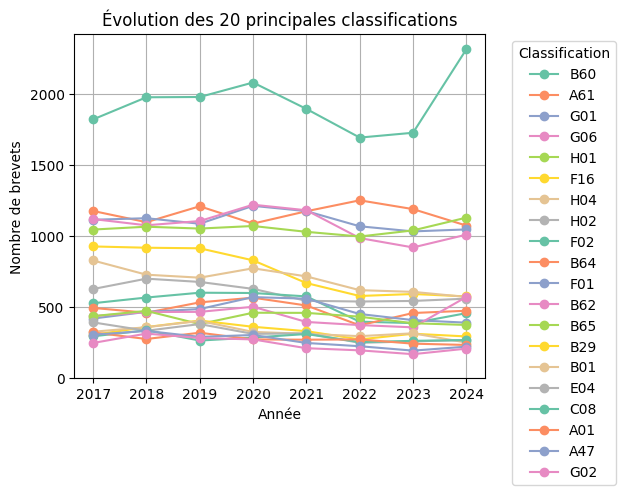

In [56]:
plot_top_classifications(stats_class3, n=20)

Les secteurs avec le plus de dépôts de brevets sont donc, par ordre décroissant : 
- `B60` : "Vehicles in general"
- `A61` : "Medical or veterinary science; Hygiene"
- `G01` : "Measuring; Testing"
- `H01` : "Electric elements"
- `G06` : "Computing or calculating; Counting"    
- `F16` : "Engineering elements or units; General measures for producing and maintaining effective functioning of machines or installations; Thermal insulation in general"
- `H04` : "Electric communication technique"
- `H02` : "Generation, conversion, or distribution of electric power"
- `F02` : "Combustion engines; Hot-gas or combustion-product engine plants"
- `B64` : "Aircraft; Aviation; Cosmonautics"

- **Nombre de brevets déposés par catégorie (quatre premiers niveaux de classification)**

In [57]:
# Garder que la première lettre de la classification
cols_classif = ["classification_1_text", "classification_2_text", "classification_3_text"]

brevets_class4 = data_brevets_light.copy()
for col in cols_classif:
    brevets_class4[col] = brevets_class4[col].str.extract(r"^([A-Z]\d{2}[A-Z])")

# Créer base compte classification
brevets_class4_long = brevets_class4.melt(
    id_vars=["doc-number", "year"],
    value_vars=cols_classif,
    value_name="classification"
)

brevets_class4_long = brevets_class4_long.dropna(subset=["classification"])

# enlever doublons intra brevets
brevets_class4_long = brevets_class4_long.drop_duplicates(
    subset=["doc-number", "year", "classification"]
)

stats_class4 = (
    brevets_class4_long
    .groupby(["classification", "year"])
    .size()
    .reset_index(name="nombre")
)

stats_class4.head(10)

,classification,year,nombre
0,A01B,2017,35
1,A01B,2018,24
2,A01B,2019,29
3,A01B,2020,25
4,A01B,2021,31
5,A01B,2022,38
6,A01B,2023,45
7,A01B,2024,25
8,A01C,2017,18
9,A01C,2018,14


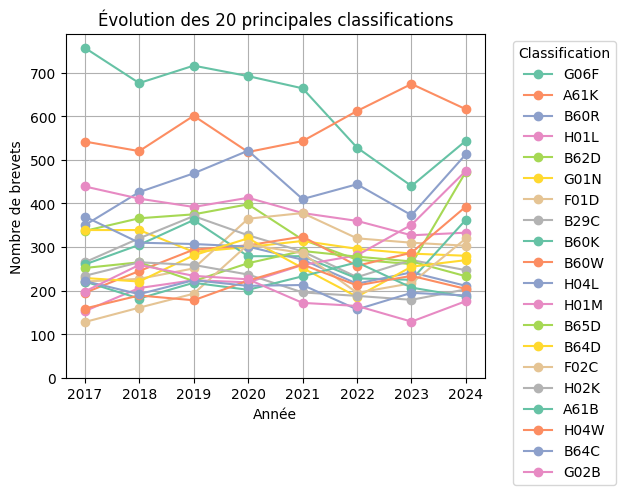

In [58]:
plot_top_classifications(stats_class4, n=20)

Par ordre décroissant entre 2017 et 2024 on a donc :
- `G06F`: "Electric digital data processing"
- `A61K`: "Preparations for medical, dental or toiletry purposes"
- `B60R`: "Vehicles, vehicle fittings, or vehicle parts, not otherwise provided for"
- `H01L`:  catégorie supprimée, anciennement "Semiconductor devices not covered by the class"
- `B62D`: "Motor vehicles; Trailers"

L'exploration des données de l'INPI entre 2017 et 2024 révèle une relative stabilité dans la hiérarchie des domaines technologiques. Les catégories B (Techniques industrielles; Transports) et G (Physique) sont les plus innovantes sur la période. 

Cependant, on observe des disparités fines lorsque l'on observe les sous-classes CIB à trois ou quatre caractères. À l'intérieur des catégories, toutes les sous-catégories n'ont pas le même volume de dépôt de brevets. Le segment des véhicules (B60) est celui avec le plus de brevets rattachés et est assez volatile, ce qui pourrait signaler des virages stratégiques du secteur.

Cette première étape nous a permis d'identifier les secteurs les plus innovants. Nous garderons notamment en tête pour la suite de l'analyse le secteur des véhicules en général. Dans la partie suivante, nous allons confronter ces dynamiques technologiques aux données de marché afin de déterminer si le dépôt de brevet, en tant que signal précoce, se traduit par une création de valeur mesurable sur les cours d'actions d'Euronext.

<a id='actions'></a>
## III. Préparation des données sur les cours d'action

<a id='secteurs'></a>
### 1) Définition des secteurs

Nous utilisons maintenant la [classification WIPO](https://www.wipo.int/export/sites/www/ipstats/en/docs/wipo_ipc_technology.pdf) augmentée de certains travaux de recherches afin de définir les secteurs que nous allons étudier. Outre le nombre de donnés disponibles, le choix est guidé par l’intelligibilité de la catégorie et sa représentativité dans le secteur économique français. Pour certains secteurs, nous utilisons un regroupement déjà utilisé dans la littérature, conçu par [Schmoch, 2008](http://193.5.93.80/edocs/mdocs/classifications/en/ipc_ce_41/ipc_ce_41_5-annex1.pdf).

- **Technologie militaire et spatiale** : B63G, B64G, C06, F41, F42, F02K, F01D

- **Pharmaceuticals and medical technology**  : A61K, A61B, A61C, A61D, A61F, A61G, A61H, A61J, A61L, A61M, A61N, H05G

- **Automobile** : B62D, B60B, B60C, B60D, B60G, B60H, B60J, B60K, B60M, B60N, B60P, B60Q, B60R, B60S, B60T, F02B, F02D, F02M, F02N, F02P,F01N, F01M, F01P, F16H, B60L  
B60W, H02K, H02P, H02M, H02J

- **Mode et accessoires**  : A41B, A41C, A41D, A41F, A42B, A43B/C/D, A44B, A45C

- **Cosmétique et parfums** : A61K, A61Q, A45D, C11B

- **Télécommunication & réseaux**  : H04L, H04W, H04Q, H04M, H04J, H04B, H01Q, H01P

- **Agro-alimentaire** : A01, A23, A23L, C12, B65

- **Construction et bâtiments** : E04, E06B, E05, E02D, E01, F24, E03, F16L, G05B

In [59]:
secteurs = {
    "auto": ["B62D", "B60B", "B60C", "B60D", "B60G", "B60H", "B60J", "B60K", 
             "B60M", "B60N", "B60P", "B60Q", "B60R", "B60S", "B60T", "F02B", 
             "F02D", "F02M", "F02N", "F02P", "F01N", "F01M", "F01P", "F16H", 
             "B60L", "B60W", "H02K", "H02P", "H02M", "H02J"],
    "space_weapon": ["B63G", "B64G", "C06", "F41", "F42", "F02K", "F01D"],
    "pharma": ["A61K", "A61B", "A61C", "A61D", "A61F", "A61G", "A61H", "A61J", 
               "A61L", "A61M", "A61N", "H05G"],
    "mode": ["A41B", "A41C", "A41D", "A41F", "A42B", "A43B", "A43C", "A43D", 
             "A44B", "A45C"],
    "cosmetic": ["A61K", "A61Q", "A45D", "C11B"],
    "telecom": ["H04L", "H04W", "H04Q", "H04M", "H04J", "H04B", "H01Q", "H01P"],
    "agro": ["A01", "A23", "A23L", "C12", "B65"],
    "bat": ["E04", "E06B", "E05", "E02D", "E01", "F24", "E03", "F16L", "G05B"]
}

# Préparer les données comme avant
cols_classif = ["classification_1_text", "classification_2_text", "classification_3_text"]

brevets_prep = data_brevets_light.copy()

# Extraire les 4 premiers caractères
for col in cols_classif:
    brevets_prep[col] = brevets_prep[col].str.extract(r"^([A-Z]\d{2}[A-Z]?)")

# Créer base longue
brevets_long = brevets_prep.melt(
    id_vars=["doc-number", "publication_date"],
    value_vars=cols_classif,
    value_name="classification"
)

# Enlever les doublons intra-brevets
brevets_long = brevets_long.drop_duplicates(subset=["doc-number", "classification"])

# Convertir publication_date en datetime et extraire le mois
brevets_long["publication_date"] = pd.to_datetime(brevets_long["publication_date"])
brevets_long["mois"] = brevets_long["publication_date"].dt.to_period("M")

# Fonction pour compter les brevets par secteur
def compter_brevets_secteur(data, classifications):
    data_filtre = data[data["classification"].isin(classifications)]
    stats = (
        data_filtre
        .groupby("mois")
        .size()
        .reset_index(name="nombre_brevets")
    )
    return stats

# Créer un DataFrame pour chaque secteur
stats_secteurs = {}
for nom_secteur, classifications in secteurs.items():
    stats_secteurs[nom_secteur] = compter_brevets_secteur(brevets_long, classifications)
    stats_secteurs[nom_secteur].columns = ["mois", f"brevets_{nom_secteur}"]

# Fusionner tous les secteurs en une seule base
base_finale = stats_secteurs["auto"].copy()
for nom_secteur in list(secteurs.keys())[1:]:
    base_finale = base_finale.merge(
        stats_secteurs[nom_secteur],
        on="mois",
        how="outer"
    )

# Convertir mois en datetime (prendre le premier jour du mois)
base_finale["mois"] = base_finale["mois"].astype(str)
base_finale["date"] = pd.to_datetime(base_finale["mois"] + "-01", format="%Y-%m-%d")

# Trier par date
base_finale = base_finale.sort_values("date").reset_index(drop=True)
colonnes_brevets = [col for col in base_finale.columns if col.startswith("brevets_")]

# Remplir les NaN par 0 (mois sans brevets)
base_finale[colonnes_brevets] = base_finale[colonnes_brevets].fillna(0)

# Calculer la croissance logarithmique : ln(nombre_après / nombre_avant)
for col in colonnes_brevets:
    valeur_avant = base_finale[col].shift(1)
    valeur_apres = base_finale[col]
    
    # ln(après/avant)
    base_finale[f"croiss_log_{col}"] = np.log(valeur_apres / valeur_avant)
    
    # Remplacer les inf et -inf par NaN
    base_finale[f"croiss_log_{col}"] = base_finale[f"croiss_log_{col}"].replace([np.inf, -np.inf], np.nan)

base_finale.head(20)
print(f"\nNombre total de mois : {len(base_finale)}")
print(f"\nPériode couverte : de {base_finale['date'].min()} à {base_finale['date'].max()}")
print(f"\nColonnes disponibles : {base_finale.columns.tolist()}")



Nombre total de mois : 96

Période couverte : de 2017-01-01 00:00:00 à 2024-12-01 00:00:00

Colonnes disponibles : ['mois', 'brevets_auto', 'brevets_space_weapon', 'brevets_pharma', 'brevets_mode', 'brevets_cosmetic', 'brevets_telecom', 'brevets_agro', 'brevets_bat', 'date', 'croiss_log_brevets_auto', 'croiss_log_brevets_space_weapon', 'croiss_log_brevets_pharma', 'croiss_log_brevets_mode', 'croiss_log_brevets_cosmetic', 'croiss_log_brevets_telecom', 'croiss_log_brevets_agro', 'croiss_log_brevets_bat']


<a id='portefeuille'></a>
### 2) Création des portefeuilles

Créons les portefeuilles représentatifs, pour LVMH nous allons mettre un poids de 48.5% et dans mode uniquement (correspondant à son rapport de revenu d'activité).

- Space technology / défense :
Thales (HO) 
Safran (SAF) 
Dassault Aviation (AM) 
Eutelsat (ETL) 
Exail Technologies (EXA)

- Pharmaceuticals & medical technology :
Sanofi (SAN) 
Ipsen (IPN) 
Sartorius Stedim Biotech (DIM) 
bioMérieux (BIM) 
Euroapi (EAPI) 
Virbac (VIRP) 
Guerbet (GBT)
Vetoquinol (VETO) 

- Automobile :
Renault (RNO) 
Michelin (ML) 
Valeo (FR) 
Forvia (FRVIA) 
OPmobility (OPM) 
Akwel (AKW) 

- Mode & accessoires :
LVMH (MC) 
Hermès (RMS) 
Kering (KER) 
Christian Dior (CDI) 
SMCP (SMCP) 

- Cosmétiques & parfums :
L’Oréal (OR) 
Interparfums (ITP) 
Robertet (RBT) 


- Télécommunications & réseaux :
Orange (ORA) 
Bouygues (EN) 
OVHcloud (OVH) 
Worldline (WLN)
Teleperformance (TEP) 
 

- Agro-alimentaire :
Danone (BN) 
Pernod Ricard (RI) 
Rémy Cointreau (RCO) 
Savencia (SAVE) 
Bonduelle (BON) 
Verallia (VRLA) 
Groupe Guillin (ALGIL) 

- Construction & bâtiments :
VINCI (DG) 
Eiffage (FGR) 
Saint-Gobain (SGO) 
Schneider Electric (SU) 
Legrand (LR) 
SPIE (SPIE) 
Nexans (NEX)

In [60]:
portefeuilles = {
    "portefeuille_auto": ["RNO", "ML", "FR", "FRVIA", "OPM", "AKW"],
    "portefeuille_pharma": ["SAN", "IPN", "DIM", "BIM", "EAPI", "VIRP", "GBT", "VETO"],
    "portefeuille_space_weapon": ["HO", "SAF", "AM", "ETL", "EXA"],
    "portefeuille_mode": ["MC", "RMS", "KER", "CDI", "SMCP"],
    "portefeuille_cosmetic": ["OR", "ITP", "RBT"],
    "portefeuille_telecom": ["ORA", "EN", "OVH", "WLN", "TEP"],
    "portefeuille_agro": ["BN", "RI", "RCO", "SAVE", "BON", "VRLA", "ALGIL"],
    "portefeuille_bat": ["DG", "FGR", "SGO", "SU", "LR", "SPIE", "NEX"]
}

ponderations_speciales = {
    "MC": 0.485  # LVMH dans le portefeuille mode
}
date_fin_brevets = base_finale["date"].max()
all_tickers = [ticker for portfolio in portefeuilles.values() for ticker in portfolio]
tickers_yahoo = [f"{ticker}.PA" for ticker in all_tickers] #tickereuronext

# Télécharger les données 
data_yahoo = yf.download(
    tickers_yahoo,
    start="2017-01-01",
    end=date_fin_brevets.strftime("%Y-%m-%d"),
    progress=True
)

# Garder seulement les prix de clôture ajustés
prices = data_yahoo['Close'].copy()

# S'assurer que c'est un DataFrame (pas une Series)
if isinstance(prices, pd.Series):
    prices = prices.to_frame(name=all_tickers[0])
else:
    # Renommer les colonnes pour retirer le .PA
    prices.columns = [col.replace(".PA", "") for col in prices.columns]

# Reset index pour avoir la date en colonne
prices = prices.reset_index()
prices.columns.name = None

print(f" Shape : {prices.shape}")

# Vérifier les tickers manquants
tickers_disponibles = [col for col in prices.columns if col != "Date"]
tickers_manquants = set(all_tickers) - set(tickers_disponibles)
if tickers_manquants:
    print(f"⚠️ Tickers non trouvés sur Yahoo Finance : {tickers_manquants}")


# Convertir en données mensuelles (dernier jour du mois)
prices["Date"] = pd.to_datetime(prices["Date"])
prices_monthly = prices.set_index("Date").resample("M").last().reset_index()

def calculer_rendement_portefeuille(prices_df, tickers, poids_special=None):
    tickers_dispo = [t for t in tickers if t in prices_df.columns]
    
    if len(tickers_dispo) == 0:
        return pd.Series([np.nan] * len(prices_df))
    
    # Créer les poids
    poids = pd.Series(1.0, index=tickers_dispo)
    if poids_special:
        for ticker, weight in poids_special.items():
            if ticker in poids.index:
                poids[ticker] = weight
    
    # Normaliser les poids pour qu'ils somment à 1
    poids = poids / poids.sum()
    
    # Calculer la valeur du portefeuille (moyenne pondérée des prix)
    portefeuille_value = (prices_df[tickers_dispo] * poids).sum(axis=1)
    
    # Calculer le rendement logarithmique : ln(P_t / P_t-1)
    rendement_log = np.log(portefeuille_value / portefeuille_value.shift(1))
    
    return rendement_log

# Calculer les rendements pour chaque portefeuille
data_rendements = prices_monthly[["Date"]].copy()

for nom_portfolio, tickers in portefeuilles.items():
    print(f"  - Calcul pour {nom_portfolio}...")
    
    # Poids spécial pour LVMH dans le portefeuille mode
    poids_special = {"MC": 0.485} if nom_portfolio == "portefeuille_mode" else None
    
    # Calculer le rendement
    rendement = calculer_rendement_portefeuille(
        prices_monthly, 
        tickers, 
        poids_special
    )
    
    data_rendements[f"return_log_{nom_portfolio}"] = rendement

print(data_rendements.head(10))


# Renommer la colonne date de base_finale pour matcher
base_finale_merge = base_finale.copy()
base_finale_merge = base_finale_merge.rename(columns={"date": "Date"})

# S'assurer que les dates sont au même format (fin de mois)
base_finale_merge["Date"] = pd.to_datetime(base_finale_merge["Date"])
data_rendements["Date"] = pd.to_datetime(data_rendements["Date"])

# Normaliser les dates à la fin du mois pour les deux DataFrames
base_finale_merge["Date"] = base_finale_merge["Date"] + pd.offsets.MonthEnd(0)
data_rendements["Date"] = data_rendements["Date"] + pd.offsets.MonthEnd(0)

# Fusionner sur la date
data_complete = base_finale_merge.merge(
    data_rendements,
    on="Date",
    how="inner"
)


data_complete.head(5)


[*********************100%***********************]  46 of 46 completed


 Shape : (2029, 47)
  - Calcul pour portefeuille_auto...
  - Calcul pour portefeuille_pharma...
  - Calcul pour portefeuille_space_weapon...
  - Calcul pour portefeuille_mode...
  - Calcul pour portefeuille_cosmetic...
  - Calcul pour portefeuille_telecom...
  - Calcul pour portefeuille_agro...
  - Calcul pour portefeuille_bat...
        Date  return_log_portefeuille_auto  return_log_portefeuille_pharma  \
0 2017-01-31                           NaN                             NaN   
1 2017-02-28                      0.039118                        0.043975   
2 2017-03-31                      0.039576                       -0.011298   
3 2017-04-30                      0.043418                        0.028380   
4 2017-05-31                     -0.008124                        0.043467   
5 2017-06-30                     -0.029119                       -0.009121   
6 2017-07-31                     -0.006609                       -0.022100   
7 2017-08-31                     -0.014322  

,mois,brevets_auto,brevets_space_weapon,brevets_pharma,brevets_mode,brevets_cosmetic,brevets_telecom,brevets_agro,brevets_bat,Date,croiss_log_brevets_auto,croiss_log_brevets_space_weapon,croiss_log_brevets_pharma,croiss_log_brevets_mode,croiss_log_brevets_cosmetic,croiss_log_brevets_telecom,croiss_log_brevets_agro,croiss_log_brevets_bat,return_log_portefeuille_auto,return_log_portefeuille_pharma,return_log_portefeuille_space_weapon,return_log_portefeuille_mode,return_log_portefeuille_cosmetic,return_log_portefeuille_telecom,return_log_portefeuille_agro,return_log_portefeuille_bat
0,2017-01,233,35,79,9,31,80,3.0,34,2017-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-02,178,22,68,5,52,47,5.0,20,2017-02-28,-0.269255,-0.464306,-0.149940,-0.587787,0.517257,-0.531879,0.510826,-0.530628,0.039118,0.043975,0.038740,0.024798,0.006979,0.059730,0.018403,-0.008606
2,2017-03,409,39,135,16,102,78,5.0,44,2017-03-31,0.831932,0.572519,0.685767,1.163151,0.673729,0.506561,0.000000,0.788457,0.039576,-0.011298,0.053800,0.073500,-0.014258,0.003435,0.042092,0.059350
3,2017-04,244,30,78,6,61,64,3.0,33,2017-04-30,-0.516547,-0.262364,-0.548566,-0.980829,-0.514099,-0.197826,-0.510826,-0.287682,0.043418,0.028380,0.056194,0.074454,0.014621,0.085875,0.028739,0.056983
4,2017-05,333,27,91,17,48,65,7.0,40,2017-05-31,0.310974,-0.105361,0.154151,1.041454,-0.239673,0.015504,0.847298,0.192372,-0.008124,0.043467,0.048524,0.013953,0.077423,0.020630,0.071001,0.004821


<a id='modélisation'></a>
## IV. Modélisation

Maintenant nous allons voir si ces nouvelles variables créées sont explicatives du cours du portefeuille correspondant. Nous testerons aussi, une regression  linéaire avec des lags (en déterminant lequel est le plus optimal) si nous supposons que l'innovation prend un certains temps avant de montrer son efficacité. Même si l'effet d'annonce (réaction à T0 des marchés financiers) prend possiblement le dessus sur l'effet de valorisation.

<a id='premières_reg'></a>
### 1) Premières régressions linéaires

In [61]:
# Mapping entre secteurs de brevets et portefeuilles
correspondances = {
    "auto": "portefeuille_auto",
    "pharma": "portefeuille_pharma",
    "space_weapon": "portefeuille_space_weapon",
    "mode": "portefeuille_mode",
    "cosmetic": "portefeuille_cosmetic",
    "telecom": "portefeuille_telecom",
    "agro": "portefeuille_agro",
    "bat": "portefeuille_bat"
}

resultats_regressions = []

for secteur_brevet, nom_portefeuille in correspondances.items():
    col_croissance = f"croiss_log_brevets_{secteur_brevet}"
    col_rendement = f"return_log_{nom_portefeuille}"
    
    # Vérifier que les colonnes existent
    if col_croissance not in data_complete.columns or col_rendement not in data_complete.columns:
        continue
    
    # Extraire les données 
    df_reg = data_complete[[col_croissance, col_rendement]].dropna()
    
    if len(df_reg) < 3:
        continue
    
    X = df_reg[col_croissance].values.reshape(-1, 1)
    y = df_reg[col_rendement].values
    
    # Régression linéaire avec sklearn
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédictions
    y_pred = model.predict(X)
    
    # Métriques
    r2 = r2_score(y, y_pred)
    coefficient = model.coef_[0]
    intercept = model.intercept_
    
    # Calcul de la p-value avec scipy
    slope, intercept_scipy, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
    
    # Stocker les résultats
    resultats_regressions.append({
        "Secteur": secteur_brevet,
        "Portefeuille": nom_portefeuille,
        "N_obs": len(df_reg),
        "Coefficient_β": coefficient,
        "Constante_α": intercept,
        "R²": r2,
        "P-value": p_value,
        "Std_Error": std_err,
        "Significatif": "Oui" if p_value < 0.05 else "Non"
    })

# Créer le DataFrame des résultats
df_resultats = pd.DataFrame(resultats_regressions)
df_resultats = df_resultats.sort_values("R²", ascending=False)

df_resultats

,Secteur,Portefeuille,N_obs,Coefficient_β,Constante_α,R²,P-value,Std_Error,Significatif
0,auto,portefeuille_auto,94,-0.048161,-0.007571,0.054125,0.024040,0.020990,Oui
7,bat,portefeuille_bat,94,-0.019046,0.009204,0.022595,0.148149,0.013060,Non
6,agro,portefeuille_agro,92,-0.006823,0.000215,0.016167,0.227121,0.005610,Non
2,space_weapon,portefeuille_space_weapon,94,-0.013553,0.008528,0.012754,0.278480,0.012432,Non
1,pharma,portefeuille_pharma,94,-0.007787,0.006316,0.005616,0.472828,0.010802,Non
4,cosmetic,portefeuille_cosmetic,94,0.002042,0.009719,0.001062,0.755231,0.006532,Non
3,mode,portefeuille_mode,94,0.003346,0.014593,0.000714,0.798235,0.013051,Non
5,telecom,portefeuille_telecom,94,-0.003175,-0.000216,0.000607,0.813688,0.013435,Non


<a id='lag'></a>
### 2) Introduction de retards : prise en compte du délai d’impact de l’innovation

Nous regardons à présent si en ajustant avec un lag on améliore la significativité.

In [62]:
lags_a_tester = [0, 1, 2, 3, 6, 9, 12, 18, 24]
tous_resultats = []

for secteur_brevet, nom_portefeuille in correspondances.items():
    col_croissance = f"croiss_log_brevets_{secteur_brevet}"
    col_rendement = f"return_log_{nom_portefeuille}"
    
    # Vérifier que les colonnes existent
    if col_croissance not in data_complete.columns or col_rendement not in data_complete.columns:
        continue
    
    print(f"Secteur : {secteur_brevet}")
    
    for lag in lags_a_tester:
        # Créer le lag : décaler la croissance des brevets
        df_lag = data_complete[[col_croissance, col_rendement]].copy()
        
        # Décaler la croissance vers le haut (lag positif = impact futur)
        df_lag[f"{col_croissance}_lag{lag}"] = df_lag[col_croissance].shift(lag)
        
        # Supprimer les NaN
        df_reg = df_lag[[f"{col_croissance}_lag{lag}", col_rendement]].dropna()

        X = df_reg[f"{col_croissance}_lag{lag}"].values.reshape(-1, 1)
        y = df_reg[col_rendement].values
        
        # Régression linéaire
        model = LinearRegression()
        model.fit(X, y)
        
        # Prédictions et métriques
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        coefficient = model.coef_[0]
        intercept = model.intercept_
        
     
        slope, intercept_scipy, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
        
        # Stocker les résultats
        tous_resultats.append({
            "Secteur": secteur_brevet,
            "Lag_mois": lag,
            "N_obs": len(df_reg),
            "Coefficient_β": coefficient,
            "Constante_α": intercept,
            "R²": r2,
            "P-value": p_value,
            "Std_Error": std_err,
            "Significatif": "Oui" if p_value < 0.05 else "Non"
        })
    
    print(f"  ✓ {len(lags_a_tester)} lags testés")

print("\n" + "="*100)

# Créer le DataFrame des résultats
df_tous_resultats = pd.DataFrame(tous_resultats)

# TROUVER LE LAG OPTIMAL PAR SECTEUR


lag_optimal_par_secteur = []

for secteur in correspondances.keys():
    df_secteur = df_tous_resultats[df_tous_resultats["Secteur"] == secteur].copy()
    
    # Filtrer seulement les résultats significatifs
    df_significatif = df_secteur[df_secteur["P-value"] < 0.05]
    
    if len(df_significatif) > 0:
        # Prendre le lag avec le meilleur R² parmi les significatifs
        meilleur = df_significatif.loc[df_significatif["R²"].idxmax()]
        lag_optimal_par_secteur.append(meilleur)
        print(f"{secteur:15} → Lag optimal = {int(meilleur['Lag_mois']):2d} mois | R² = {meilleur['R²']:.4f} | p-value = {meilleur['P-value']:.6f} ")
    else:
        # Aucun lag significatif, prendre le meilleur R² quand même
        meilleur = df_secteur.loc[df_secteur["R²"].idxmax()]
        lag_optimal_par_secteur.append(meilleur)
        print(f"{secteur:15} → Meilleur lag = {int(meilleur['Lag_mois']):2d} mois | R² = {meilleur['R²']:.4f} | p-value = {meilleur['P-value']:.6f} (non significatif)")

# DataFrame des lags optimaux
df_lags_optimaux = pd.DataFrame(lag_optimal_par_secteur)


print(df_lags_optimaux[["Secteur", "Lag_mois", "N_obs", "Coefficient_β", "R²", "P-value", "Significatif"]].to_string(index=False))


# Afficher tous les résultats triés par secteur et R²
df_tous_resultats_sorted = df_tous_resultats.sort_values(["Secteur", "R²"], ascending=[True, False])
print(df_tous_resultats_sorted.to_string(index=False))


nb_significatifs = len(df_lags_optimaux[df_lags_optimaux["Significatif"] == "Oui"])
print(f"Secteurs avec lag significatif (p < 0.05) : {nb_significatifs}/{len(correspondances)}")
print(f"Meilleur R² global : {df_lags_optimaux['R²'].max():.4f} ({df_lags_optimaux.loc[df_lags_optimaux['R²'].idxmax(), 'Secteur']})")
print(f"Lag moyen optimal : {df_lags_optimaux['Lag_mois'].mean():.1f} mois")

Secteur : auto
  ✓ 9 lags testés
Secteur : pharma
  ✓ 9 lags testés
Secteur : space_weapon
  ✓ 9 lags testés
Secteur : mode
  ✓ 9 lags testés
Secteur : cosmetic
  ✓ 9 lags testés
Secteur : telecom
  ✓ 9 lags testés
Secteur : agro
  ✓ 9 lags testés
Secteur : bat
  ✓ 9 lags testés

auto            → Lag optimal =  1 mois | R² = 0.0898 | p-value = 0.003530 
pharma          → Meilleur lag =  1 mois | R² = 0.0322 | p-value = 0.085477 (non significatif)
space_weapon    → Meilleur lag =  6 mois | R² = 0.0243 | p-value = 0.147110 (non significatif)
mode            → Meilleur lag =  1 mois | R² = 0.0182 | p-value = 0.196710 (non significatif)
cosmetic        → Meilleur lag =  2 mois | R² = 0.0122 | p-value = 0.294715 (non significatif)
telecom         → Lag optimal =  1 mois | R² = 0.0514 | p-value = 0.028805 
agro            → Lag optimal =  1 mois | R² = 0.0722 | p-value = 0.009998 
bat             → Lag optimal =  1 mois | R² = 0.0421 | p-value = 0.048498 
     Secteur  Lag_mois  N_obs  Coef

Réaliser un lag d'au moins 1 mois rend la moitié des régressions univariables significatives. C'est intéressant car cela suggère que la croissance du nombres de brevets d'aujourd'hui explique le cours du mois suivant. Il est donc raisonnable de tenter de faire des prédictions avec des séries temporelles. Ce que nous allons faire et back-tester.

<a id='modélisation_auto'></a>
### 3) Modélisation dans le secteur Automobile
Dans cette section, nous isolons le secteur automobile afin de tester la robustesse du signal "Brevet" sur les rendements boursiers. Nous réaliserons un test de stationnarité, une identification du lag optimal, et une validation des hypothèses de Gauss-Markov. 
L'analyse pour le secteur Automobile qui a un lag optimal de 1 mois et p-value significative de 0.016. Nous vérifions d'abord les hypothèses des MCO puis nous réalisons un ensemble de tests et de corrections pour s'assurer de la véracité de la méthode MCO avant de procéder aux tests de modèles de prédictions.

Nombre d'observations après lag : 93


ÉTAPE 1 : TESTS DE STATIONNARITÉ (ADF)

Variable X : Croissance log brevets (avec lag)
ADF Statistic : -6.191389
P-value       : 0.000001
Valeurs critiques :
  1%: -4.074
  5%: -3.465
  10%: -3.159
Série STATIONNAIRE (p-value < 0.05)

Variable Y : Rendement log portefeuille
ADF Statistic : -10.296100
P-value       : 0.000000
Valeurs critiques :
  1%: -4.061
  5%: -3.459
  10%: -3.156
Série STATIONNAIRE (p-value < 0.05)
INTERPRÉTATION :
Les deux séries sont stationnaires, on peut procéder à la régression.


RÉGRESSION MCO AVEC LAG


ÉTAPE 2 : TESTS DES HYPOTHÈSES MCO

TEST 1 : NORMALITÉ DES RÉSIDUS (Jarque-Bera)

Statistique JB : 2.4673
P-value        : 0.291228
Skewness       : -0.1983
Kurtosis       : 3.6924

H₀ acceptée : Les résidus suivent une distribution normale

Graphique sauvegardé : output/normalite_residus_auto.png


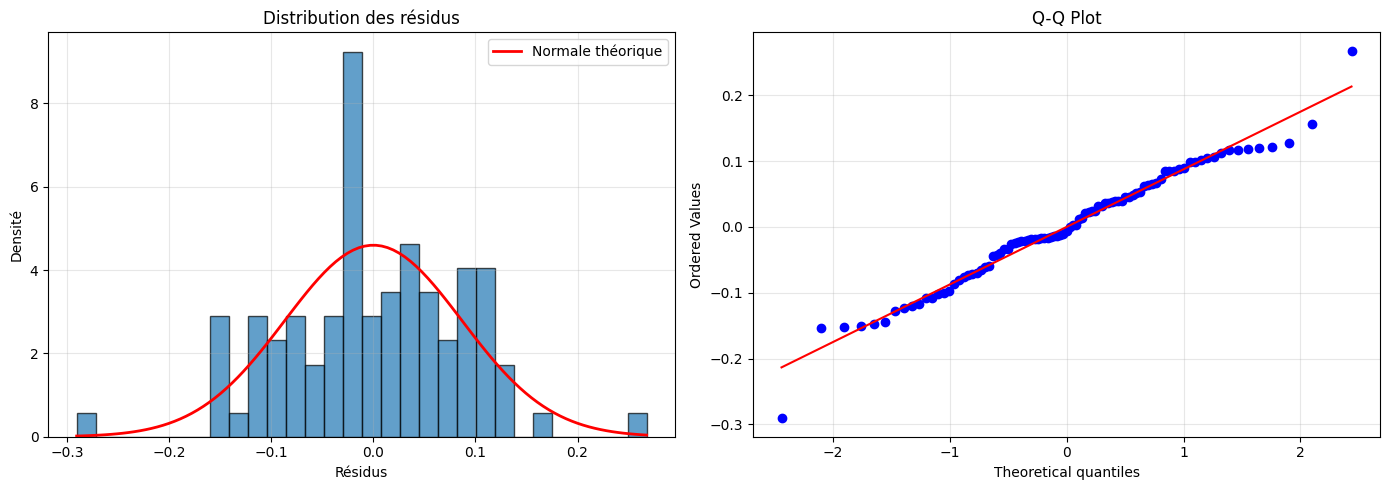


TEST 2 : HÉTÉROSCÉDASTICITÉ (White)

LM Statistic   : 3.6277
P-value (LM)   : 0.163023
F-statistic    : 1.8266
P-value (F)    : 0.166875

H₀ acceptée : Il y a HOMOSCÉDASTICITÉ
Les erreurs ont une variance constante

Graphique sauvegardé : output/heteroscedasticite_auto.png


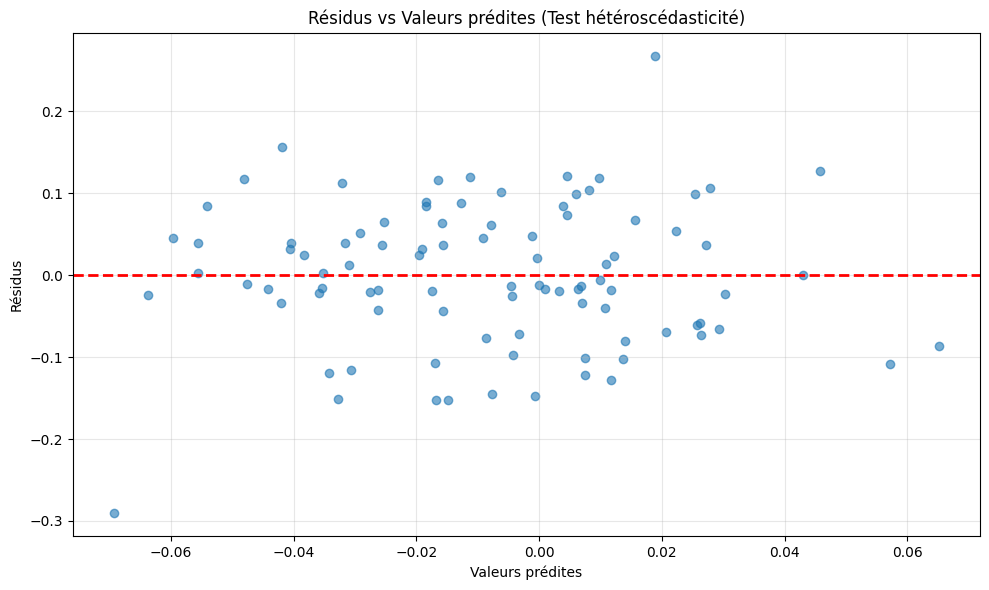


TEST 3 : AUTOCORRÉLATION (Durbin-Watson)

Statistique DW : 2.0454

Interprétation :
  DW ≈ 2     : Pas d'autocorrélation
  DW < 1.5   : Autocorrélation positive
  DW > 2.5   : Autocorrélation négative

Pas d'autocorrélation détectée (DW entre 1.5 et 2.5)


ÉTAPE 5 : CORRECTION DU MODÈLE

RÉSUMÉ DES TESTS :
Normalité des résidus : OUI
Homoscédasticité      : OUI
Non-autocorrélation   : OUI

CONCLUSION : Tous les tests sont bons -> Pas de correction nécessaire

MODÈLE FINAL :
rendement(t) = -0.008593 + 0.061933 × croissance_brevets(t-1)
P-value : 0.003530
R² : 0.0898


In [63]:
secteur = "auto"
col_croissance = f"croiss_log_brevets_{secteur}"
col_rendement = f"return_log_portefeuille_{secteur}"

# Préparer les données
df_auto = data_complete[['Date', col_croissance, col_rendement]].copy()

# Récupérer le lag optimal
lag_optimal = int(df_lags_optimaux[df_lags_optimaux["Secteur"] == secteur]["Lag_mois"].values[0])

# Créer le lag
df_auto[f"{col_croissance}_lag{lag_optimal}"] = df_auto[col_croissance].shift(lag_optimal)
df_auto = df_auto.dropna()

print(f"Nombre d'observations après lag : {len(df_auto)}")
# ÉTAPE 1 : Tests de stationnarité  (ADF)

print("\n\nÉTAPE 1 : TESTS DE STATIONNARITÉ (ADF)")

def test_adf(serie, nom):
    result = adfuller(serie.dropna(), regression='ct')
    
    print(f"\n{nom}")
    print(f"ADF Statistic : {result[0]:.6f}")
    print(f"P-value       : {result[1]:.6f}")
    print(f"Valeurs critiques :")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] < 0.05:
        print(f"Série STATIONNAIRE (p-value < 0.05)")
        return True
    else:
        print(f"Série NON STATIONNAIRE (p-value > 0.05)")
        return False

stat_croissance = test_adf(df_auto[f"{col_croissance}_lag{lag_optimal}"], "Variable X : Croissance log brevets (avec lag)")
stat_rendement = test_adf(df_auto[col_rendement], "Variable Y : Rendement log portefeuille")

print("INTERPRÉTATION :")
if stat_croissance and stat_rendement:
    print("Les deux séries sont stationnaires, on peut procéder à la régression.")
else:
    print("Au moins une série n'est pas stationnaire. Problème potentiel de régression fallacieuse.")

# RÉGRESSION MCO AVEC LAG

print("\n\nRÉGRESSION MCO AVEC LAG")

X = df_auto[f"{col_croissance}_lag{lag_optimal}"].values
y = df_auto[col_rendement].values
X_with_const = sm.add_constant(X)

model_simple = OLS(y, X_with_const).fit()

# étape 2 : tests hypothèses MCO

print("\n\nÉTAPE 2 : TESTS DES HYPOTHÈSES MCO")

residus = model_simple.resid

print("\nTEST 1 : NORMALITÉ DES RÉSIDUS (Jarque-Bera)")

jb_result = stats.jarque_bera(residus)
jb_stat = jb_result.statistic
jb_pvalue = jb_result.pvalue
skew = stats.skew(residus)
kurtosis = stats.kurtosis(residus, fisher=False)  # fisher=False pour avoir kurtosis normal (3 = normal)

print(f"\nStatistique JB : {jb_stat:.4f}")
print(f"P-value        : {jb_pvalue:.6f}")
print(f"Skewness       : {skew:.4f}")
print(f"Kurtosis       : {kurtosis:.4f}")

if jb_pvalue < 0.05:
    print(f"\nH₀ rejetée : Les résidus NE suivent PAS une distribution normale")
    print(f"Excès de kurtosis détecté ({kurtosis:.2f}, normal = 3)")
else:
    print(f"\nH₀ acceptée : Les résidus suivent une distribution normale")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residus, bins=30, density=True, alpha=0.7, edgecolor='black')
mu, std = residus.mean(), residus.std()
x = np.linspace(residus.min(), residus.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Normale théorique')
axes[0].set_xlabel('Résidus')
axes[0].set_ylabel('Densité')
axes[0].set_title('Distribution des résidus')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

stats.probplot(residus, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
path_normalite = os.path.join("output", f"normalite_residus_{secteur}.png")
plt.savefig(path_normalite, dpi=300)

print(f"\nGraphique sauvegardé : {path_normalite}")
plt.show()

# TEST 2 : HÉTÉROSCÉDASTICITÉ (White)

print("\nTEST 2 : HÉTÉROSCÉDASTICITÉ (White)")

white_test = het_white(residus, X_with_const)
lm_stat, lm_pvalue, f_stat, f_pvalue = white_test

print(f"\nLM Statistic   : {lm_stat:.4f}")
print(f"P-value (LM)   : {lm_pvalue:.6f}")
print(f"F-statistic    : {f_stat:.4f}")
print(f"P-value (F)    : {f_pvalue:.6f}")

if lm_pvalue < 0.05:
    print(f"\nH₀ rejetée : Il y a HÉTÉROSCÉDASTICITÉ")
    print(f"Les erreurs n'ont pas une variance constante")
    print(f"Correction de White nécessaire")
    hetero = True
else:
    print(f"\nH₀ acceptée : Il y a HOMOSCÉDASTICITÉ")
    print(f"Les erreurs ont une variance constante")
    hetero = False

# Visualisation
y_pred = model_simple.fittedvalues
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residus, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Résidus vs Valeurs prédites (Test hétéroscédasticité)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
path_hetero = os.path.join("output", f"heteroscedasticite_{secteur}.png")
plt.savefig(path_hetero, dpi=300)

print(f"\nGraphique sauvegardé : {path_hetero}")
plt.show()

# TEST 3 : AUTOCORRÉLATION (Durbin-Watson)

print("\nTEST 3 : AUTOCORRÉLATION (Durbin-Watson)")

dw_stat = durbin_watson(residus)

print(f"\nStatistique DW : {dw_stat:.4f}")
print(f"\nInterprétation :")
print(f"  DW ≈ 2     : Pas d'autocorrélation")
print(f"  DW < 1.5   : Autocorrélation positive")
print(f"  DW > 2.5   : Autocorrélation négative")

if 1.5 < dw_stat < 2.5:
    print(f"\nPas d'autocorrélation détectée (DW entre 1.5 et 2.5)")
    autocorr = False
else:
    print(f"\nAutocorrélation possible (DW hors de [1.5, 2.5])")
    autocorr = True

# ÉTAPE 5 : CORRECTION DU MODÈLE

print("\n\nÉTAPE 5 : CORRECTION DU MODÈLE")

print("\nRÉSUMÉ DES TESTS :")
print(f"Normalité des résidus : {'NON' if jb_pvalue < 0.05 else 'OUI'}")
print(f"Homoscédasticité      : {'NON' if hetero else 'OUI'}")
print(f"Non-autocorrélation   : {'NON' if autocorr else 'OUI'}")

if hetero and not autocorr:
    print("\nCONCLUSION : Hétéroscédasticité détectée -> Correction de White nécessaire")
    
    model_corrected = OLS(y, X_with_const).fit(cov_type='HC3')
    
    print("\nRÉSULTATS APRÈS CORRECTION DE WHITE :")
    print(model_corrected.summary())
    
    print(f"\nCOEFFICIENTS APRÈS CORRECTION :")
    print(f"β₀ (Constante)  : {model_corrected.params[0]:.6f}")
    print(f"β₁ (Pente)      : {model_corrected.params[1]:.6f}")
    print(f"P-value (β₁)    : {model_corrected.pvalues[1]:.6f}")
    
    if model_corrected.pvalues[1] < 0.05:
        print("\nLe coefficient reste significatif après correction")
    else:
        print("\nLe coefficient n'est plus significatif après correction")
    
    model_final = model_corrected
    
elif not hetero and not autocorr:
    print("\nCONCLUSION : Tous les tests sont bons -> Pas de correction nécessaire")
    model_final = model_simple
    
else:
    print("\nCONCLUSION : Problèmes multiples détectés")
    print("Considérer des modèles plus avancés (GARCH, etc.)")
    model_final = model_simple

beta_0_final = model_final.params[0]
beta_1_final = model_final.params[1]
p_value_final = model_final.pvalues[1]

print(f"\nMODÈLE FINAL :")
print(f"rendement(t) = {beta_0_final:.6f} + {beta_1_final:.6f} × croissance_brevets(t-{lag_optimal})")
print(f"P-value : {p_value_final:.6f}")
print(f"R² : {model_final.rsquared:.4f}")


Ici, nous observons qu'aucune correction est nécessaire.

<a id='model_temporel'></a>
### 4) Modélisation temporelle des rendements dans le secteur automobile

Maintenant nous faisons des tests de prédictions via des outils d'analyse de série temporelle et de back-testing pour trouver le modèle de prédiction le plus performant (le modèle le plus performant étant celui minimisant le MSE (Mean Squarred Error) et le MAE (Mean Average error)).

Nous comparerons les modèles suivant AR/MA; EMWA; AR/MA + correction GARCH; et naïf (T-1 prédisant T).

Tout d'abord trouvons le modèle AR/MA avec les meilleurs paramètres, le choix se fondant sur l'optimisation du BIC (nous nous limitons aux paramètres 5). Ensuite nous vérifions que le modèle trouvé est valide via plusieurs tests sur les résidus (White, Jarque-Bera)

In [64]:
# Éetape 6 : modèle AR/ARMA 

print("\n\étape 6 : MODÈLES AR/ARMA ")

# Utiliser les rendements sans lag 
rendements_series = df_auto[col_rendement]

max_p = 5  #AR maximum
max_q = 5  #MA maximum

modeles_candidats = []

# Tester tous les modèles AR(p) 
for p in range(1, max_p + 1):
    modeles_candidats.append(('AR', p, 0))

# Tester tous les modèles MA(q) 
for q in range(1, max_q + 1):
    modeles_candidats.append(('MA', 0, q))

# Tester tous les modèles ARMA(p,q) pour p,q = 1 à 3 
for p in range(1, 4):
    for q in range(1, 4):
        modeles_candidats.append(('ARMA', p, q))

# Estimer tous les modèles et stocker les résultats
resultats_modeles = []

for nom_type, p, q in modeles_candidats:
    try:
        # Estimer le modèle
        model = ARIMA(rendements_series, order=(p, 0, q)).fit()
        
        # Calculer les critères
        aic = model.aic
        bic = model.bic
        hqic = model.hqic
        
        # Test de Ljung-Box sur les résidus
        residus = model.resid
        lb_test = acorr_ljungbox(residus, lags=[10], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].values[0]
        
        # Test d'hétéroscédasticité de White
        try:
            white_test = het_white(residus.dropna(), sm.add_constant(np.arange(len(residus.dropna()))))
            white_pvalue = white_test[1]
        except:
            white_pvalue = np.nan
        
        # Nom du modèle
        if q == 0:
            nom_modele = f"AR({p})"
        elif p == 0:
            nom_modele = f"MA({q})"
        else:
            nom_modele = f"ARMA({p},{q})"
        
        # Stocker les résultats
        resultats_modeles.append({
            'Modèle': nom_modele,
            'p': p,
            'q': q,
            'AIC': aic,
            'BIC': bic,
            'HQIC': hqic,
            'LB_pvalue': lb_pvalue,
            'White_pvalue': white_pvalue,
            'model_obj': model
        })
        
    except Exception as e:
        print(f"Erreur avec modèle ({p},{q}) : {str(e)}")
        continue

df_resultats = pd.DataFrame(resultats_modeles)

# Identifier le meilleur modèle selon BIC
df_resultats_sorted = df_resultats.sort_values('BIC')
meilleur_modele_info = df_resultats_sorted.iloc[0]

# Récupérer le modèle optimal
modele_optimal = meilleur_modele_info['model_obj']
nom_modele_optimal = meilleur_modele_info['Modèle']

print(f"Modèle AR\MA OPTIMAL : {nom_modele_optimal}")


# Tests de validation détaillés du modèle optimal

residus_optimal = modele_optimal.resid

# 1. Test d'autocorrélation des résidus (Ljung-Box)
print("\n1. Test de Ljung-Box (autocorrélation des résidus)")
lb_test_detail = acorr_ljungbox(residus_optimal, lags=[5, 10, 15, 20], return_df=True)
print(lb_test_detail)
if lb_test_detail['lb_pvalue'].min() > 0.05:
    print(f"✓ Pas d'autocorrélation significative des résidus de {nom_modele_optimal} ")
else:
    print("✗ Autocorrélation des résidus détectée")

# 2. Test d'hétéroscédasticité (White)
print("\n2. Test de White (hétéroscédasticité)")
white_test = het_white(residus_optimal.dropna(), sm.add_constant(np.arange(len(residus_optimal.dropna()))))
print(f"Statistique LM : {white_test[0]:.4f}")
print(f"P-value        : {white_test[1]:.6f}")
if white_test[1] > 0.05:
    print("✓ Homoscédasticité (bon modèle)")
else:
    print("✗ Hétéroscédasticité détectée")

# 3. Test de normalité des résidus (Jarque-Bera)
from scipy import stats
print("\n3. Test de Jarque-Bera (normalité des résidus)")
jb_stat, jb_pvalue = stats.jarque_bera(residus_optimal.dropna())
print(f"Statistique JB : {jb_stat:.4f}")
print(f"P-value        : {jb_pvalue:.6f}")
if jb_pvalue > 0.05:
    print("✓ Résidus normalement distribués")
else:
    print("✗ Résidus non normalement distribués")


# Stocker le modèle optimal pour utilisation ultérieure
meilleur_modele_ar = modele_optimal
nom_meilleur = nom_modele_optimal




\étape 6 : MODÈLES AR/ARMA 
Modèle AR\MA OPTIMAL : MA(1)

1. Test de Ljung-Box (autocorrélation des résidus)
      lb_stat  lb_pvalue
5    0.713292   0.982231
10   6.549147   0.767212
15  13.443190   0.568107
20  15.898365   0.722909
✓ Pas d'autocorrélation significative des résidus de MA(1) 

2. Test de White (hétéroscédasticité)
Statistique LM : 4.2440
P-value        : 0.119791
✓ Homoscédasticité (bon modèle)

3. Test de Jarque-Bera (normalité des résidus)
Statistique JB : 22.3781
P-value        : 0.000014
✗ Résidus non normalement distribués


Le modèle optimal trouvé MA(1), malgré la non normalité des résidus, reste donc acceptable.

In [65]:
#Etape 7 : GARCH
# Test ARCH pour justifier GARCH (sur les résidus du modèle AR/ARMA optimal)

residus_arma = meilleur_modele_ar.resid  # Résidus du AR/ARMA optimal
arch_test = het_arch(residus_arma, nlags=5)

if arch_test[1] < 0.05:
    print("\nH₀ rejetée : Il y a hétéroscédasticité conditionnelle")
    print(f"Un modèle {nom_meilleur}-GARCH est recommandé")
    garch_pertinent = True
else:
    print("\nH₀ acceptée : Pas d'hétéroscédasticité conditionnelle")
    print("Un modèle GARCH n'est pas nécessaire")
    garch_pertinent = False

# Estimer ARMA-GARCH si pertinent
if garch_pertinent:
    rendements_garch = df_auto[col_rendement] * 100  # Multiplier par 100 pour stabilité numérique
    # Extraire p et q du modèle optimal
    # Parser le nom du modèle (ex: "AR(2)" ou "ARMA(1,1)")
    if 'MA' in nom_meilleur and 'ARMA' not in nom_meilleur:  # MA(q)
        q_optimal = int(nom_meilleur.split('(')[1].split(')')[0])
        p_optimal = 0
    elif 'ARMA' in nom_meilleur:  # ARMA(p,q)
        parts = nom_meilleur.split('(')[1].split(')')[0].split(',')
        p_optimal = int(parts[0])
        q_optimal = int(parts[1])
    else:  # AR(p)
        p_optimal = int(nom_meilleur.split('(')[1].split(')')[0])
        q_optimal = 0
    
    print(f"\nEstimation {nom_meilleur}-GARCH(1,1)")
    print(f"Ordre AR/ARMA : p={p_optimal}, q={q_optimal}")
    
    # Adapter selon le type de modèle
    if q_optimal == 0 and p_optimal > 0:  # AR(p)
        garch_model = arch_model(rendements_garch, vol='Garch', p=1, q=1, 
                                 mean='AR', lags=p_optimal)
    elif p_optimal == 0 and q_optimal > 0:  # MA(q)
        garch_model = arch_model(rendements_garch, vol='Garch', p=1, q=1, 
                                 mean='MA', lags=q_optimal)
    else:  # ARMA(p,q)
        garch_model = arch_model(rendements_garch, vol='Garch', p=1, q=1, 
                                 mean='ARMA', lags=[p_optimal, q_optimal])
    
    garch_fit = garch_model.fit(disp='off')
    
    
    # Vérifier condition de stationnarité
    alpha = garch_fit.params['alpha[1]']
    beta = garch_fit.params['beta[1]']
    somme = alpha + beta
    
    if somme < 1:
        print(f"✓ Le modèle est stationnaire (α + β < 1)")
        print(f"  Persistance de la volatilité : {beta:.4f}")
    else:
        print("✗ ATTENTION : Le modèle n'est PAS stationnaire (α + β >= 1)")
    
    
else:
    print("\nPas de modèle GARCH estimé (non pertinent)")
    garch_fit = None  # ✅ Stocker None si pas de GARCH




H₀ acceptée : Pas d'hétéroscédasticité conditionnelle
Un modèle GARCH n'est pas nécessaire

Pas de modèle GARCH estimé (non pertinent)


Ici il est n'est donc pas pertinant d'utiliser un modèle GARCH. (développer?)

Il ne reste plus qu'à tester le modèle EMWA.

Pour les prédictions via MCO nous séparons le jeux de donné de la manière suivante : 20 % pour le train et 80% pour les tests.

In [66]:
#Etape 8 : EWMA
print("\n\nÉTAPE 8 : MODÈLE EWMA")
# Trouver alpha optimal
ewma_model = ExponentialSmoothing(rendements_series, trend=None, seasonal=None).fit()
alpha_ewma = ewma_model.params['smoothing_level']

print(f"\nAlpha optimal : {alpha_ewma:.6f}")

#Etape 9 : Prédictions et comparaison

print("\n\nÉTAPE 9 : PRÉDICTIONS ET COMPARAISON")

# Séparer train/test (80/20)
n_train = int(len(rendements_series) * 0.8)
train = rendements_series[:n_train]
test = rendements_series[n_train:]

print(f"\nTrain : {len(train)} observations")
print(f"Test  : {len(test)} observations")

# Modèle 1 : MCO 
X_train = df_auto[f"{col_croissance}_lag{lag_optimal}"].iloc[:n_train].values
X_test = df_auto[f"{col_croissance}_lag{lag_optimal}"].iloc[n_train:].values
y_train = train.values
y_test = test.values

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model_mco_pred = OLS(y_train, X_train_const).fit()
pred_mco = model_mco_pred.predict(X_test_const)

mse_mco = mean_squared_error(y_test, pred_mco)
mae_mco = mean_absolute_error(y_test, pred_mco)


# Modèle 2 AR\MA Optimal
if 'MA' in nom_meilleur and 'ARMA' not in nom_meilleur:
    q_opt = int(nom_meilleur.split('(')[1].split(')')[0])
    p_opt = 0
elif 'ARMA' in nom_meilleur:
    parts = nom_meilleur.split('(')[1].split(')')[0].split(',')
    p_opt = int(parts[0])
    q_opt = int(parts[1])
else:
    p_opt = int(nom_meilleur.split('(')[1].split(')')[0])
    q_opt = 0

arma_pred_model = ARIMA(train, order=(p_opt, 0, q_opt)).fit()
pred_arma = arma_pred_model.forecast(steps=len(test))

mse_arma = mean_squared_error(test, pred_arma)
mae_arma = mean_absolute_error(test, pred_arma)

# Modèle 3 : EWMA
pred_ewma = []
last_value = train.iloc[-1]
for i in range(len(test)):
    pred_ewma.append(last_value)
    if i < len(test):
        last_value = alpha_ewma * test.iloc[i] + (1 - alpha_ewma) * last_value

mse_ewma = mean_squared_error(test, pred_ewma)
mae_ewma = mean_absolute_error(test, pred_ewma)

# Modèle 4 : ARMA-GARCH (si estimé à l'étape 6)
if garch_pertinent and garch_fit is not None:
    # Préparer les données train/test pour GARCH
    rendements_train = df_auto[col_rendement].iloc[:n_train] * 100
    rendements_test = df_auto[col_rendement].iloc[n_train:] * 100
    
    # Réentraîner le modèle GARCH sur train
    if q_opt == 0 and p_opt > 0:
        garch_train = arch_model(rendements_train, vol='Garch', p=1, q=1, 
                                 mean='AR', lags=p_opt)
    elif p_opt == 0 and q_opt > 0:
        garch_train = arch_model(rendements_train, vol='Garch', p=1, q=1, 
                                 mean='MA', lags=q_opt)
    else:
        garch_train = arch_model(rendements_train, vol='Garch', p=1, q=1, 
                                 mean='ARMA', lags=[p_opt, q_opt])
    
    garch_fit_train = garch_train.fit(disp='off')
    
    # Prédictions GARCH (moyenne conditionnelle)
    forecasts_garch = garch_fit_train.forecast(horizon=len(test), reindex=False)
    pred_garch = forecasts_garch.mean.values[-1, :] / 100  # Rediviser par 100
    
    mse_garch = mean_squared_error(test, pred_garch)
    mae_garch = mean_absolute_error(test, pred_garch)
    print(f"MSE : {mse_garch:.8f}")
    print(f"MAE : {mae_garch:.8f}")
    
    garch_inclus = True
else:
    print("\n\nMODÈLE 4 : GARCH non estimé (non pertinent)")
    garch_inclus = False

# Modèle 5 : Prédiction Naïve (T expliqué par T-1)
pred_naive = train.iloc[-1:].values.tolist() + test.iloc[:-1].values.tolist()
pred_naive = np.array(pred_naive)

mse_naive = mean_squared_error(test, pred_naive)
mae_naive = mean_absolute_error(test, pred_naive)

# Comparaison finale

print("\n\nCOMPARAISON FINALE DES MODÈLES")

if garch_inclus:
    resultats_pred = pd.DataFrame({
        'Modèle': ['MCO ', nom_meilleur, 'EWMA', 'Naïf (T-1)', f'{nom_meilleur}-GARCH(1,1)'],
        'MSE': [mse_mco, mse_arma, mse_ewma, mse_naive, mse_garch],
        'MAE': [mae_mco, mae_arma, mae_ewma, mae_naive, mae_garch]
    })
else:
    resultats_pred = pd.DataFrame({
        'Modèle': ['MCO', nom_meilleur, 'EWMA', 'Naïf (T-1)'],
        'MSE': [mse_mco, mse_arma, mse_ewma, mse_naive],
        'MAE': [mae_mco, mae_arma, mae_ewma, mae_naive]
    })
resultats_pred = resultats_pred.sort_values('MSE')
print(resultats_pred.to_string(index=False))

meilleur_pred = resultats_pred.iloc[0]['Modèle']
print(f"\n\nMEILLEUR MODÈLE PRÉDICTIF : {meilleur_pred}")
print(f"MSE : {resultats_pred.iloc[0]['MSE']:.8f}")
print(f"MAE : {resultats_pred.iloc[0]['MAE']:.8f}")



ÉTAPE 8 : MODÈLE EWMA

Alpha optimal : 0.000000


ÉTAPE 9 : PRÉDICTIONS ET COMPARAISON

Train : 74 observations
Test  : 19 observations


MODÈLE 4 : GARCH non estimé (non pertinent)


COMPARAISON FINALE DES MODÈLES
    Modèle      MSE      MAE
       MCO 0.005469 0.059511
     MA(1) 0.005475 0.060505
      EWMA 0.007304 0.070311
Naïf (T-1) 0.012766 0.092947


MEILLEUR MODÈLE PRÉDICTIF : MCO
MSE : 0.00546862
MAE : 0.05951071


Le résultat est plus que satisfaisant, nous pourrions faire pareil pour l'ensemble des secteurs en remplaçant uniquement la variable "secteur" par le secteur que nous voulons étudier.

Il serait donc intéressant d'établir une stratégie utilisant le modèle MCO trouvé, en gardant en tête qu'un lag de 1 mois a été utilisé. En effet, ce modèle nous indique que nous pouvons prédire les rendements logarithmiques du portefeuille d'actions du secteur automobile du mois suivant en fonction de l'augmentation du nombre de brevets du mois actuel, que nous classifions dans ce secteur selon la méthodologie précédente, avec une Mean squarred error de 0.005.

<a id='indicateur'></a>
### 5) Création d'un indicateur et stratégie de trading systématique

Dans le cadre du secteur automobile 

<a id='conclusion'></a>
## Conclusion et perspectives

Dans ce projet, nous avons donc étudié les liens entre les flux de dépôts de brevets de l'INPI et la valorisation boursière sur Euronext Paris en regardant certains secteurs et grosses entreprises associées. Nos analyses économétriques indiquent que le dépôt de brevet constitue un signal informationnel significatif, bien que son impact varie selon les secteurs. 

Afin d'approfondir ce projet, nous pouvons identifier plusieurs pistes d'améliorations et analyses complémentaires :
- Réaliser la même analyse en exploitant les brevets validés par l'INPI. Ces données sont disponibles sur le serveur FTP de l'INPI mais sont plus difficiles à exploiter car mises à jour régulièrement, là où les demandes n'évoluent pas dans le temps. Voir en quoi les résultats diffèrent pour les brevets validés pourrait être très intéressant.
- Nous aurions aimé exploiter davantage les abstracts (ou résumés) et les titres de brevets présents dans notre base. Il aurait été enrichissant d'étudier les mots clés associés au différents secteurs, voire l'émergence de nouveaux mots clés au cours du temps (ex : covid, IA, etc.).
- De plus, nous pensons qu'entraîner un algorithme de Natural Language Processing (NLP) capable de classer sémantiquement les résumés (abstracts) des brevets directement selon les secteurs stratégiques retenus aurait pu bien fonctionner avec notre base de données. Un tel modèle nous aurait permis de s'affranchir de la rigidité des codes CIB pour construire une classification par secteurs plus souples et propices à analyser les cours financiers.
